Puzzle generation code for the Executive Functioning Task(https://pavlovia.org/katielavigne/executive-function)

Developed by Caroline DAKOURE

# Executive Functioning task statement

---



1.        Puzzle Setup: The game board has a grid with colored blocks arranged in a specific pattern.
The blocks are initially located in the last row of the grid, either alone or on top of another block.
There are no blocks that end up without a block beneath them (except for the last row of the grid).
No more than 2 blocks of the same color are horizontally or vertically aligned. Each colour must have at least 3 blocks.
2.        Game Play: The player's goal is to remove all blocks from the grid in as few moves as possible.
3.        Available Moves:
1.        a. Simple Move: The player can move a block one cell to the left or right if the target cell is empty.
2.        b. Exchange: The player can swap a block with the one to its left or right, if the target cell is occupied.
4.        Elimination Rule: If more than 2 blocks of the same color are aligned horizontally or vertically, then all aligned blocks disappear.
5.        Falling Rule: If there is no block beneath a block, then the block falls until it is supported by another block or it reaches the bottom row of the grid.
6.        Winning Condition: The player wins when all blocks are removed from the grid in a minimum number of moves. Wrong moves can cause the player to fail to clear all the blocks.

# Choose the batch generation settings

In [ ]:
blocks_range = (3, 12)
colors_range = (1, 3)
colors_blocks = ['blue', 'red', 'gray']
nb_moves = 5
stack_probability = 0.7
blocks_gap = 1

# Implement the Puzzle Setup

Utility functions

In [ ]:
!pip3 install --no-index matplotlib

In [ ]:
# Will randomly assign a color to each block
import logging
logging.getLogger().setLevel(logging.INFO)

def assign_blocks_per_color(nb_blocks, colors):
  blocks_per_color = []
  nb_blocks_to_assign = nb_blocks

  for i in range(0, len(colors)):
    blocks_per_color.append([colors[i], 3])
    nb_blocks_to_assign = nb_blocks_to_assign-3

  while nb_blocks_to_assign != 0:
    random_color = random.choice(colors) # select color
    random_blocks = random.randint(0, nb_blocks_to_assign)
    blocks_per_color = [[color, value + random_blocks] if color == random_color else [color, value] for color, value in blocks_per_color]
    nb_blocks_to_assign = nb_blocks_to_assign-random_blocks
  return blocks_per_color

# Some utilities function
def sort_blocks_by_rows(set_blocks):
  set_blocks = dict(sorted(set_blocks.items(), key=lambda x: x[0]))
  #logging.debug("Sorted blocks by row: ", set_blocks)
  return set_blocks

def sort_blocks_by_columns(set_blocks):
  set_blocks = dict(sorted(set_blocks.items(), key=lambda x: x[0][1]))
  #logging.debug("Sorted blocks by column: ", set_blocks)
  return set_blocks

In [ ]:
#assign_blocks_per_color(nb_blocks=nb_blocks, colors=colors)

Block Class: This class represents the individual blocks on the game board.

In [ ]:
class Block:
  def __init__(self, color):
    self.color = color

  def set_color(self, color):
    self.color = color

  def get_color(self):
    return self.color

  def __str__(self):
    return f"Colored {self.color} block"

  def __repr__(self):
    return f"<Color: {self.color}>"

Grid Initializer: This class can handle the setup of the game board, including generating the initial configuration of blocks.

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys, random
mpl.rcParams['figure.max_open_warning'] = 50  # Increase the maximum number of warnings
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import colors

class GridInitializer:
    def __init__(self, grid_size, nb_blocks, colors, min_nb_moves, stack_probability, blocks_gap):
        self.grid_size = grid_size
        self.nb_blocks = nb_blocks
        self.colors = colors
        self.set_blocks = {}
        self.min_nb_moves = min_nb_moves
        self.stack_probability = stack_probability
        self.blocks_gap = blocks_gap

    def is_valid_position(self, row, col):
        if row < 0 or row >= self.grid_size[0] or col < 0 or col >= self.grid_size[1]:
            return False
        return True

    def is_block_present(self, row, col):
      if self.is_valid_position(row, col):
        if (row, col) in self.set_blocks:
          block = self.set_blocks[(row, col)]
          block_color = block.color
        else:
          block_color = None
        return [block_color is not None, block_color]
      return [False, None]

    def is_similar_block(self, row, col, color):
        block_present = self.is_block_present(row, col)
        if self.is_valid_position(row, col) and block_present[0] and block_present[1] == color:
            return True

    def check_valid_placement(self, row, col, color):
        if self.is_similar_block(row + 1, col, color) and self.is_similar_block(row + 2, col, color):
            return False
        if self.is_similar_block(row, col-1, color) and self.is_similar_block(row, col+1, color):
            return False
        if self.is_similar_block(row, col-1, color) and self.is_similar_block(row, col-2, color):
            return False
        if self.is_similar_block(row, col+1, color) and self.is_similar_block(row, col+2, color):
            return False
        return True

    def get_highest_positions(self):
        highest_positions = {}
        for position in self.set_blocks:
            row, col = position
            if col not in highest_positions or row < highest_positions[col][0]:
                highest_positions[col] = (row, col)

        highest_block_positions = list(highest_positions.values())
        #print(f"get_highest_block_positions: {highest_block_positions}")
        return highest_block_positions

    def select_random_highest_position(self):
        highest_block_positions = self.get_highest_positions()
        highest_block_positions_filtered = [(row, col) for row, col in highest_block_positions if row != 0]
        if not highest_block_positions_filtered:
            return self.select_empty_positions_with_gap()
        random_position = random.choice(highest_block_positions_filtered)
        #print(f"select_random_highest_position: {random_position}")
        return (random_position[0]-1,random_position[1])

    def get_empty_positions_with_gap(self):
        last_row = self.grid_size[0] - 1
        empty_positions_with_gap = []
        highest_positions = self.get_highest_positions()

        for row, col in highest_positions:
            adjacent_cols = [col + self.blocks_gap, col + self.blocks_gap + 1, col - self.blocks_gap, col - self.blocks_gap - 1]
            adjacent_cols = [adj_col for adj_col in adjacent_cols if adj_col >= 0 and adj_col < self.grid_size[1]]

            for adj_col in adjacent_cols:
                adjacent_position = (last_row, adj_col)
                if adjacent_position not in self.set_blocks:
                    empty_positions_with_gap.append(adjacent_position)

        #print(f"get_empty_positions_with_gap: {empty_positions_with_gap}")
        return empty_positions_with_gap

    def select_empty_positions_with_gap(self):
        empty_positions_with_gap = self.get_empty_positions_with_gap()
        if not empty_positions_with_gap:
            return self.select_random_highest_position()
        random_position = random.choice(empty_positions_with_gap)
        #print(f"select_empty_positions_with_gap: {random_position}")
        return random_position

    def initialize_grid(self):
        blocks_per_color = assign_blocks_per_color(self.nb_blocks, self.colors)
        blocks_to_place = [color for color, count in blocks_per_color for i in range(count)]
        while blocks_to_place:
            placed = False
            while not(placed):
                stacked = False
                if random.random() < self.stack_probability:
                    stacked = True
                random_block_index = random.randrange(len(blocks_to_place))
                random_block_color = blocks_to_place[random_block_index]
                if not self.set_blocks:
                    random_column_grid = math.floor(self.grid_size[1]/2)
                    selected_row = self.grid_size[0]-1
                elif not stacked:
                    random_position = self.select_empty_positions_with_gap()
                    random_column_grid = random_position[1]
                    selected_row = random_position[0]
                if stacked and self.set_blocks:
                    random_position = self.select_random_highest_position()
                    #print(f"Random stacked position: {random_position}")
                    random_column_grid = random_position[1]
                    selected_row = random_position[0]

                if self.check_valid_placement(selected_row, random_column_grid, random_block_color):
                    block = Block(random_block_color)
                    self.set_blocks[(selected_row, random_column_grid)] = block
                    placed = True
            blocks_to_place.pop(random_block_index)
        self.set_blocks = sort_blocks_by_rows(self.set_blocks)

    def change_set_blocks(self, set_blocks):
      self.set_blocks = set_blocks

    @staticmethod
    def init_graphical_grid(set_blocks, grid_size):
      grid = [['white' for _ in range(grid_size[1])] for _ in range(grid_size[0])]
      for position, block in set_blocks.items():
          row, col = position
          grid[row][col] = block.color

      # Create a new figure and axis
      fig, ax = plt.subplots()

      # Hide the axis ticks and labels
      ax.axis('off')

      # Iterate over the grid and plot colored rectangles for each data point
      for row in range(grid_size[0]):
        for col in range(grid_size[1]):
          color = grid[row][col]
          rect = plt.Rectangle((col,grid_size[0] - row - 1), 1, 1, facecolor=color, edgecolor='black')
          ax.add_patch(rect)

      return fig, ax, grid

    def print_initial_grid(self):
        fig, ax, grid = GridInitializer.init_graphical_grid(self.set_blocks, self.grid_size)
        # Set the plot limits to include all cells
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, self.grid_size[1] + 0.5)
        ax.set_ylim(-0.5, self.grid_size[0] + 0.5)
        # Show the plot
        print("Here is the randomly-created Puzzle: ")
        plt.show()

        print("\nOr a shorter representation: \n", self.set_blocks)

PuzzleLogic Class: This class have methods responsible for the game's core logic. This includes checking for block elimination, enforcing gravity rules (e.g., making blocks fall down after elimination), and performing player moves (e.g., swapping two adjacent blocks).

# Implement the moves and rules

In [ ]:
from collections import Counter, deque
class PuzzleLogic():
  def __init__(self):
    return

  # Check if it's possible to do a simple move = move to an empty space to the left or right
  def check_all_available_moves(self, current_position, color, set_blocks, grid_size):
    possible_moves = {
        'move_left': self.can_move_left(current_position, set_blocks),
        'move_right': self.can_move_right(current_position, set_blocks, grid_size),
        'exchange_left': self.can_exchange_left(current_position, color, set_blocks),
        'exchange_right': self.can_exchange_right(current_position, color, set_blocks, grid_size)
    }
    #logging.debug(f"Currently examining block in position: {current_position}, Possible moves: {possible_moves}, Set of blocks: {set_blocks}")
    return possible_moves

  def can_move_left(self, position, set_blocks):
      row, col = position
      if col > 0:
          left_position = (row, col - 1)
          return left_position not in set_blocks
      return False

  def can_move_right(self, position, set_blocks, grid_size):
      row, col = position
      if col < grid_size[1] - 1:
          right_position = (row, col + 1)
          return right_position not in set_blocks
      return False

  def can_exchange_left(self, position, color, set_blocks):
      row, col = position
      if col > 0:
          left_position = (row, col - 1)
          return left_position in set_blocks and color != set_blocks[left_position].color
      return False

  def can_exchange_right(self, position, color, set_blocks, grid_size):
      row, col = position
      if col < grid_size[1] - 1:
          right_position = (row, col + 1)
          return right_position in set_blocks and color != set_blocks[right_position].color
      return False

  def update_block(self, old_position, new_position, set_blocks):
    # Update the position of the block
    saved_block = set_blocks.pop(old_position)
    set_blocks[new_position] = saved_block
    set_blocks = sort_blocks_by_rows(set_blocks)
    return set_blocks

  def exchange_block(self, first_position, second_position, set_blocks):
    #logging.debug(f"Exchanging first position: {first_position} with second_position: {second_position} in this set of blocks: {set_blocks}")
    block_1 = set_blocks[first_position]
    block_2 = set_blocks[second_position]
    set_blocks[first_position] = block_2
    set_blocks[second_position] = block_1
    set_blocks = sort_blocks_by_rows(set_blocks)
    return set_blocks

  def has_matches(self, set_blocks):
    return bool(self.find_matches(set_blocks))

  def find_matches(self, set_blocks):
    matches = set()

    matches |= self.find_matches_by_rows(set_blocks)
    matches |= self.find_matches_by_columns(set_blocks)

    #print("Matches found: ", matches)
    return matches

  def find_matches_by_rows(self, set_blocks):
      matches = set()

      set_blocks_row = sort_blocks_by_rows(set_blocks)
      matches |= self.find_matches_in_iterator(set_blocks_row.items(), is_same_row=True)

      return matches

  def find_matches_by_columns(self, set_blocks):
      matches = set()

      set_blocks_column = sort_blocks_by_columns(set_blocks)
      matches |= self.find_matches_in_iterator(set_blocks_column.items(), is_same_row=False)

      return matches

  def find_matches_in_iterator(self, set_blocks, is_same_row):
      matches = set()
      tmp_matches = set()
      nb_aligned = 1

      try:
          iterator = iter(set_blocks)
          (position, block) = next(iterator)
          while True:
              (next_position, next_block) = next(iterator)
              #print(f"position: {position}, color: {block.color}, next position: {next_position}, next color: {next_block.color}")

              if self.is_aligned(position, next_position, block, next_block, is_same_row):
                  nb_aligned += 1
                  tmp_matches.add(position)
                  tmp_matches.add(next_position)
              else:
                  nb_aligned = 1
                  tmp_matches = set()

              if nb_aligned >= 3:
                  matches |= tmp_matches

              position, block = next_position, next_block

      except StopIteration:
          pass

      return matches

  def delete_matches(self, set_blocks, matches):
    new_set_blocks = set_blocks.copy()
    for key in matches:
      if key in new_set_blocks:
        del new_set_blocks[key]
    #logging.debug("New set of blocks after matches elimination: ", new_set_blocks)
    return new_set_blocks

  def is_aligned(self, position, next_position, block, next_block, is_same_row):
      if is_same_row:
          return position[0] == next_position[0] and position[1] == next_position[1] - 1 and block.color == next_block.color
      else:
          return position[1] == next_position[1] and position[0] == next_position[0] - 1 and block.color == next_block.color

  def has_gravity(self, set_blocks, grid_size):
    return bool(self.apply_gravity(set_blocks, grid_size) != set_blocks)

  def apply_gravity(self, set_blocks, grid_size):
    new_set_blocks = set_blocks.copy()
    for position in reversed(set_blocks): #check gravity from bottom to top
        row, col = position
        underneath_position = (row + 1, col)

        while underneath_position[0] < grid_size[0] and underneath_position not in new_set_blocks:
          underneath_position = (underneath_position[0] + 1, underneath_position[1])

        new_position = (underneath_position[0] - 1, underneath_position[1])
        if new_position != position:
          new_set_blocks = self.update_block(position, new_position, new_set_blocks)
          #logging.debug(f"Changed block in position {position} which has fallen to position {new_position}")
    #logging.debug(f"New set of blocks after gravity rule applied: {new_set_blocks}")
    return new_set_blocks

  def apply_gravity_and_eliminate_matches(self, set_blocks, grid_size):
    new_set_blocks = set_blocks.copy()
    while True:
        new_set_blocks_before = new_set_blocks.copy()
        new_set_blocks = self.apply_gravity(new_set_blocks, grid_size)
        new_set_blocks = self.delete_matches(new_set_blocks,self.find_matches(new_set_blocks))
        if new_set_blocks == new_set_blocks_before:
            break
    return new_set_blocks

  def make_move(self, move_type, position, set_blocks):
    #logging.debug(f"Doing the following move: {move_type} with set of blocks: {set_blocks}")
    if move_type == "move_left":
        set_blocks = self.make_simple_move(position, "left", set_blocks)
    elif move_type == "move_right":
        set_blocks = self.make_simple_move(position, "right", set_blocks)
    elif move_type == "exchange_left":
        set_blocks = self.make_exchange_move(position, "left", set_blocks)
    elif move_type == "exchange_right":
        set_blocks = self.make_exchange_move(position, "right", set_blocks)
    #else:
        #print("No proper move to do")
    return set_blocks

  def make_simple_move(self, position, direction, set_blocks):
    if direction == "left":
      new_position = (position[0], position[1]-1)
      set_blocks = self.update_block(position, new_position, set_blocks)
    elif direction == "right":
      new_position = (position[0], position[1]+1)
      set_blocks = self.update_block(position, new_position, set_blocks)
    return set_blocks

  def make_exchange_move(self, position, direction, set_blocks):
    if direction == "left":
      new_position = (position[0], position[1]-1)
      set_blocks = self.exchange_block(position, new_position, set_blocks)
    elif direction == "right":
      new_position = (position[0], position[1]+1)
      set_blocks = self.exchange_block(position, new_position, set_blocks)
    return set_blocks

  def get_game_state(self, set_blocks, colors):
    if not set_blocks:
      #logging.debug("This is a victory. All blocks have been removed.")
      return 3
    elif not self.has_valid_block_color_counts(set_blocks, colors):
      #logging.debug("This is a defeat, as the puzzle can't be solved with the current number of blocks.")
      return 2
    else:
      #logging.debug("The game is still in progress.")
      return 1

  def has_valid_block_color_counts(self, set_blocks, colors):
    color_counts = self.count_block_colors(set_blocks)
    for color in colors:
        if color_counts[color] == 1 or color_counts[color] == 2:
            return False
        else:
            return True

  def count_block_colors(self, set_blocks):
    color_counts = Counter(block.color for block in set_blocks.values())
    return color_counts


  def check_state_after_move(self):
    #perform elimination and gravity rules until state is correct
    return

  #game_state

# Implement a BFS

BFSSolver Class: This class takes an instance of the game logic class as input and use it to simulate and solve the puzzle. The solving algorithm is implemented using breadth-first search (BFS).

In [ ]:
import numpy as np

class BFSSolver:
  def __init__(self, grid_initializer, puzzle_logic):
    self.grid_initializer = grid_initializer
    self.puzzle_logic = puzzle_logic

  # Iterate over the blocks and apply the functions
  def perform_all_blocks_moves(self):

    min_moves_to_solve = self.grid_initializer.min_nb_moves
    initial_set_blocks = self.grid_initializer.set_blocks.copy()
    grid_size = self.grid_initializer.grid_size
    colors = self.grid_initializer.colors

    queue = deque()
    current_round = 0
    initial_node = {
        "set_blocks_history": [initial_set_blocks],
        "moves_types_history": [],
        "moved_blocks_history" : [],
        "rounds_number_history": [1],
        "puzzle_states_history" : [1]
    }
    queue.append(initial_node)

    #print(f"\n\n..::SOLVER STEP:.. Checking if the puzzle has a solution in {min_moves_to_solve} moves\n")
    while queue:
      current_item = queue.popleft()

      set_blocks = current_item["set_blocks_history"][-1].copy()
      current_round = current_item["rounds_number_history"][-1]
      if current_round > min_moves_to_solve:
        break
      puzzle_state = current_item["puzzle_states_history"][-1]

      #logging.debug(f"\n\nWe are simulating round: {current_round} and the following set of blocks: {set_blocks} \n")

      if puzzle_state == 1:
        is_solvable, solution = self.process_possible_moves(set_blocks, current_item, current_round, grid_size, colors, queue)
        if is_solvable:
          return True, solution
    print(f"Did not find a solution in {current_round-1} moves. See the queue")
    return False, {}

  def process_possible_moves(self, set_blocks, current_item, current_round, grid_size, colors, queue):
      for position, block in set_blocks.items():
        possible_moves = self.puzzle_logic.check_all_available_moves(position, block.color, set_blocks, grid_size)
        for move_type in ['move_left', 'move_right', 'exchange_left', 'exchange_right']:
          updated_blocks = set_blocks.copy()
          if possible_moves[move_type]:
            updated_blocks = self.puzzle_logic.make_move(move_type, position, updated_blocks)
            updated_blocks = self.puzzle_logic.apply_gravity_and_eliminate_matches(updated_blocks, grid_size)
            state = self.puzzle_logic.get_game_state(updated_blocks, colors)

            next_node = {
                      "set_blocks_history": current_item["set_blocks_history"] + [updated_blocks],
                      "moves_types_history": current_item["moves_types_history"] + [move_type],
                      "moved_blocks_history" : current_item["moved_blocks_history"] + [position],
                      "rounds_number_history": current_item["rounds_number_history"] + [current_round+1],
                      "puzzle_states_history" : current_item["puzzle_states_history"] + [state]
            }
            queue.append(next_node)
            if state == 3:
              solution = self.process_solution(next_node, current_round)
              return True, solution
      return False, {}

  def process_solution(self, solved_puzzle_dict, current_round):
      solved_puzzle_dict["moves_types_history"].append('')
      solved_puzzle_dict["moved_blocks_history"].append(())

      print(f"Found a solution: {solved_puzzle_dict['set_blocks_history']} in {current_round} moves \n")
      return solved_puzzle_dict

  @staticmethod
  def print_history(solved_puzzle_dict, grid_size, show, ax=None):
    set_blocks_history = solved_puzzle_dict["set_blocks_history"]
    moved_blocks_history = solved_puzzle_dict["moved_blocks_history"]
    moves_types_history = solved_puzzle_dict["moves_types_history"]
    rounds_number_history = solved_puzzle_dict["rounds_number_history"]

    if ax is None:
        num_subplots = len(set_blocks_history)
        fig, ax = plt.subplots(1, num_subplots, figsize=(num_subplots * 6, 8), sharey=True, **{"squeeze": False})
        #plt.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95)

    for i in range(len(set_blocks_history)):
        set_blocks = set_blocks_history[i]
        move_type = moves_types_history[i]
        position = moved_blocks_history[i]
        round = rounds_number_history[i]
        title = ""

        grid = [['white' for _ in range(grid_size[1])] for _ in range(grid_size[0])]
        for pos, block in set_blocks.items():
            row, col = pos
            grid[row][col] = block.color

        for row in range(grid_size[0]):
            for col in range(grid_size[1]):
                color = grid[row][col]
                rect = plt.Rectangle((col, grid_size[0] - row - 1), 1, 1, facecolor=color, edgecolor='black')
                ax[0, i].add_patch(rect)

        if i == 0:
            title = f"..::SOLUTION::..: Solvable in {rounds_number_history[-2]} moves (blocks positions: {set_blocks})\n\nINITIAL STATE: "

        if i != len(set_blocks_history) - 1:
            title += f"(MOVE {round}) \nPerform: {move_type} at position: {position}:"
            ax[0, i], grid = BFSSolver.highlight_moved_block(set_blocks, position, ax[0, i], grid, grid_size)
            ax[0, i], grid = BFSSolver.draw_arrow(set_blocks, position, move_type, ax[0, i], grid, grid_size)
        else:
            title = "FINAL STATE"

        ax[0, i].set_aspect('equal')
        ax[0, i].axis('off')
        ax[0, i].set_xlim(-0.5, grid_size[1] + 0.5)
        ax[0, i].set_ylim(-0.5, grid_size[0] + 0.5)
        ax[0, i].set_title(title, loc='left')

    if show:
        plt.tight_layout()
        plt.show()

  @staticmethod
  def highlight_moved_block(set_blocks, position, ax, grid, grid_size):
      arrow_pos_row = position[0]
      arrow_pos_col = position[1]
      color = grid[arrow_pos_row][arrow_pos_col]
      rect = plt.Rectangle((arrow_pos_col, grid_size[0] - arrow_pos_row - 1), 1, 1, facecolor=color, edgecolor='lime', linewidth=2)
      ax.add_patch(rect)
      return ax, grid

  @staticmethod
  def draw_arrow(set_blocks, position, move_type, ax, grid, grid_size):
      arrow_pos_row = position[0]
      arrow_pos_col = position[1]
      linecol = "lime"
      arrow = BFSSolver.create_fancy_arrow_patch(arrow_pos_col, arrow_pos_row, move_type, linecol, grid_size)
      ax.add_patch(arrow)
      return ax, grid

  @staticmethod
  def create_fancy_arrow_patch(arrow_pos_col, arrow_pos_row, move_type, linecol, grid_size):
      if move_type == "move_left":
          arrow_start = (arrow_pos_col - 0.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow_end = (arrow_pos_col + 0.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow = FancyArrowPatch(arrow_start, arrow_end, arrowstyle='<-', mutation_scale=30, linewidth=2, color=linecol)
      elif move_type == "move_right":
          arrow_start = (arrow_pos_col + 0.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow_end = (arrow_pos_col + 1.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow = FancyArrowPatch(arrow_start, arrow_end, arrowstyle='->', mutation_scale=30, linewidth=2, color=linecol)
      elif move_type == "exchange_left":
          arrow_start = (arrow_pos_col - 0.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow_end = (arrow_pos_col + 0.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow = FancyArrowPatch(arrow_start, arrow_end, arrowstyle='<->', mutation_scale=30, linewidth=2, color=linecol)
      elif move_type == "exchange_right":
          arrow_start = (arrow_pos_col + 0.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow_end = (arrow_pos_col + 1.5, grid_size[0] - arrow_pos_row - 0.5)
          arrow = FancyArrowPatch(arrow_start, arrow_end, arrowstyle='<->', mutation_scale=30, linewidth=2, color=linecol)
      return arrow

# Call the classes

Now, let's generate a lot of puzzles

In [ ]:
import datetime
import csv
import os
from matplotlib.backends.backend_pdf import PdfPages

class PuzzleBatchGenerator:
    def __init__(self, blocks_range, colors_range, colors_blocks, nb_moves):
        self.blocks_range = blocks_range
        self.colors_range = colors_range
        self.colors = colors_blocks
        self.nb_moves = nb_moves
        self.puzzle_batch = {}
        self.nb_solvables = 0
        self.nb_unsolvables = 0
        self.stats = {}
        self.csv_data = {}

    def generate_puzzles(self):
        iterated_colors = []
        puzzle_batch = {}
        csv_data = {
            "cubes": [],
            "positions": [],
            "colors": [],
            "moves": []
        }
        stack_probability = 0.6
        blocks_gap = 1

        for i in range(1, nb_moves+1):
            key = 'solvable_in_' + str(i) + '_moves'
            puzzle_batch[key] = []

        for nb_colors in range(self.colors_range[0], self.colors_range[1] + 1):
            iterated_colors = self.colors[:nb_colors]
            for nb_blocks in range(self.blocks_range[0], self.blocks_range[1]+1):
                if len(iterated_colors)*3 > nb_blocks:
                    #print('Not enough blocks for the number of colors. You need at least 3 blocks per color.')
                    continue
                else:
                    if nb_colors == 1:
                        grid_size = (nb_blocks+1, nb_blocks+1)
                    else:
                        grid_size = (12,6)
                    is_solvable = False
                    print(f"Generating puzzle for {nb_blocks} blocks, {iterated_colors} colors. The size of the grid is: {grid_size}.")
                    nb_attempts = 0
                    while not(is_solvable) and nb_attempts < 5:
                        grid = GridInitializer(grid_size, nb_blocks, iterated_colors, self.nb_moves, stack_probability, blocks_gap)
                        grid.initialize_grid()
                        solver = BFSSolver(grid, PuzzleLogic())
                        is_solvable, solution = solver.perform_all_blocks_moves()
                        nb_attempts = nb_attempts + 1
                    if is_solvable:
                        round = solution["rounds_number_history"][-2]
                        key = 'solvable_in_' + str(round) + '_moves'
                        puzzle_batch[key] = puzzle_batch[key] + [(solution, grid_size)]

                        positions_list = []
                        colors_list = []

                        init_pos = solution['set_blocks_history'][0]
                        for position, block in init_pos.items():
                            positions_list.append(position)
                            color = block.get_color()
                            colors_list.append(color)

                        csv_data["cubes"] = csv_data["cubes"] + [nb_blocks]
                        csv_data["colors"] = csv_data["colors"] + [colors_list]
                        csv_data["positions"] = csv_data["positions"] + [positions_list]
                        csv_data["moves"] = csv_data["moves"] + [round]
                        self.nb_solvables = self.nb_solvables + 1
                    else:
                        self.nb_unsolvables = self.nb_unsolvables + 1

        self.puzzle_batch = puzzle_batch
        self.csv_data = csv_data
        print("Batch generation completed.")
        return self.puzzle_batch



    def print_and_save_batch(self):
        for move in sorted(self.puzzle_batch.keys()):
          list_solved_puzzles = self.puzzle_batch[move]
          for i in range(len(list_solved_puzzles)):
            solved_puzzle = list_solved_puzzles[i][0]
            grid_size = list_solved_puzzles[i][1]
            #print(f"This is the list of puzzles generated for: {move}")
            BFSSolver.print_history(solved_puzzle, grid_size, False)
        self.print_charts(False)
        filename = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")+'_puzzle_generation.pdf'
        self.save_multi_image(filename)

    def save_multi_image(self, filename):
        pp = PdfPages(filename)
        fig_nums = plt.get_fignums()
        figs = [plt.figure(n) for n in fig_nums]
        for fig in figs:
          fig.savefig(pp, format='pdf')
        pp.close()
        self.save_file(filename)
        plt.show()

    def compute_stats(self): #so that we can do Pie chart, Bar chart, tables..
        for move in sorted(self.puzzle_batch.keys()):
          self.stats[move] = len(self.puzzle_batch[move])
        print("stats: ", self.stats)

    def set_batch(self, batch):
        self.puzzle_batch = batch

    def print_charts(self, show):
        labels = list(self.stats.keys()) + ['unsolvable']
        sizes = list(self.stats.values()) + [self.nb_unsolvables]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        ax1.bar(labels, sizes)
        ax1.set_title('Number of Puzzles Generated (Bar Chart)')

        ax2.pie(sizes, labels=labels, autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sum(sizes)))
        ax2.set_title('Number of Puzzles Generated (Pie Chart)')

        fig.tight_layout()

        if show:
          plt.show()

    def save_results_as_csv(self):
        filename = str(datetime.datetime.now()) + '_puzzle_generation.csv'
        fieldnames = list(self.csv_data.keys())
        with open(filename, "w", newline="") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(self.csv_data["cubes"])):
                writer.writerow({fieldname: self.csv_data[fieldname][i] for fieldname in fieldnames})
        self.save_file(filename)


    def save_file(self, filename):
        # Check if running in Google Colab
        if 'google.colab' in str(get_ipython()):
            from google.colab import files
            files.download(filename)
            print("Looks like we are on google colab so we file would be saved on our Kernel")
        else:
            # Save the file locally in the current working directory
            current_dir = os.getcwd()
            new_file_path = os.path.join(current_dir, filename)
            os.rename(filename, new_file_path)
            print(f"File saved locally at: {new_file_path}")

In [ ]:
batch_generator = PuzzleBatchGenerator(blocks_range, colors_range, colors_blocks, nb_moves)

In [ ]:
batch = batch_generator.generate_puzzles()

Generating puzzle for 3 blocks, ['blue'] colors. The size of the grid is: (4, 4).
Found a solution: [{(2, 2): <Color: blue>, (3, 0): <Color: blue>, (3, 2): <Color: blue>}, {}] in 1 moves 

Generating puzzle for 4 blocks, ['blue'] colors. The size of the grid is: (5, 5).
Found a solution: [{(3, 3): <Color: blue>, (4, 0): <Color: blue>, (4, 2): <Color: blue>, (4, 3): <Color: blue>}, {(3, 2): <Color: blue>, (4, 0): <Color: blue>, (4, 2): <Color: blue>, (4, 3): <Color: blue>}, {}] in 2 moves 

Generating puzzle for 5 blocks, ['blue'] colors. The size of the grid is: (6, 6).
Did not find a solution in 5 moves. See the queue
Found a solution: [{(4, 1): <Color: blue>, (4, 3): <Color: blue>, (5, 1): <Color: blue>, (5, 3): <Color: blue>, (5, 5): <Color: blue>}, {(4, 3): <Color: blue>, (5, 0): <Color: blue>, (5, 1): <Color: blue>, (5, 3): <Color: blue>, (5, 5): <Color: blue>}, {(4, 3): <Color: blue>, (5, 0): <Color: blue>, (5, 1): <Color: blue>, (5, 3): <Color: blue>, (5, 4): <Color: blue>}, {}]

stats:  {'solvable_in_1_moves': 1, 'solvable_in_2_moves': 5, 'solvable_in_3_moves': 7, 'solvable_in_4_moves': 3, 'solvable_in_5_moves': 4}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Looks like we are on google colab so we file would be saved on our Kernel


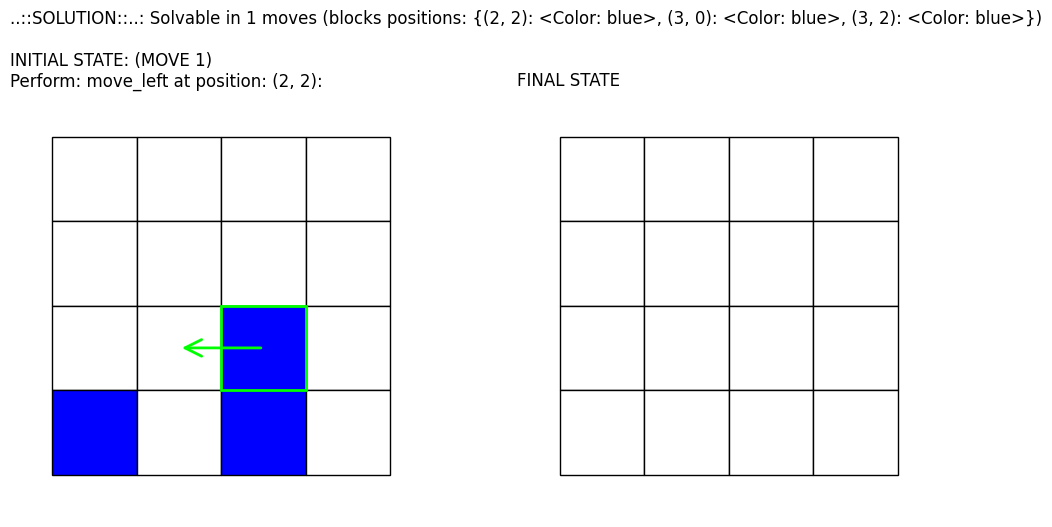

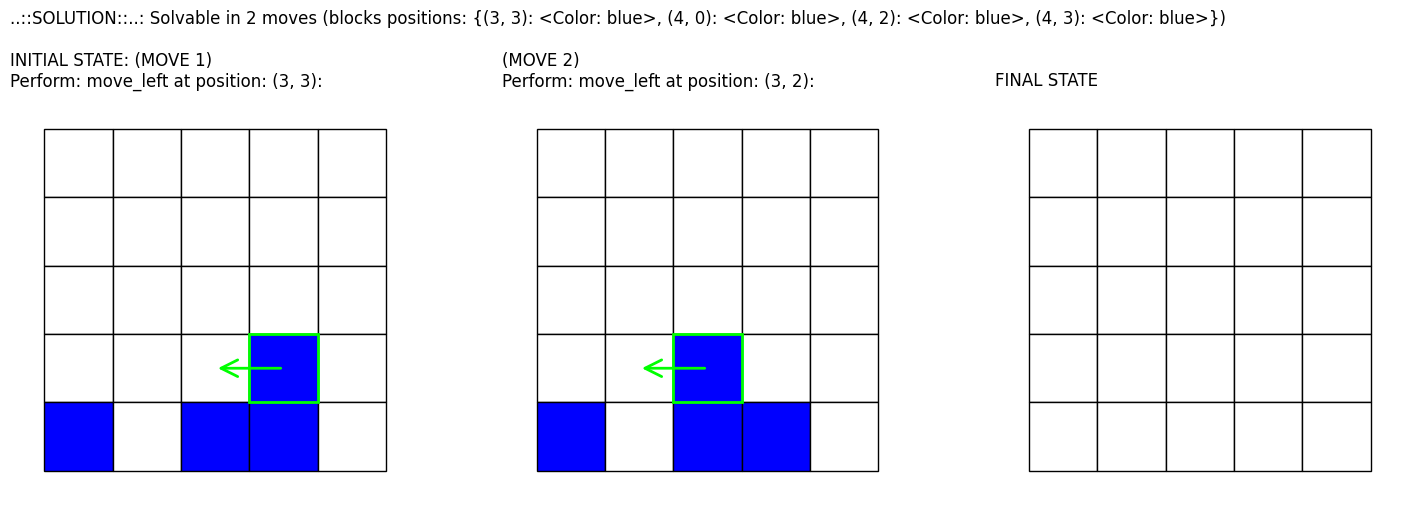

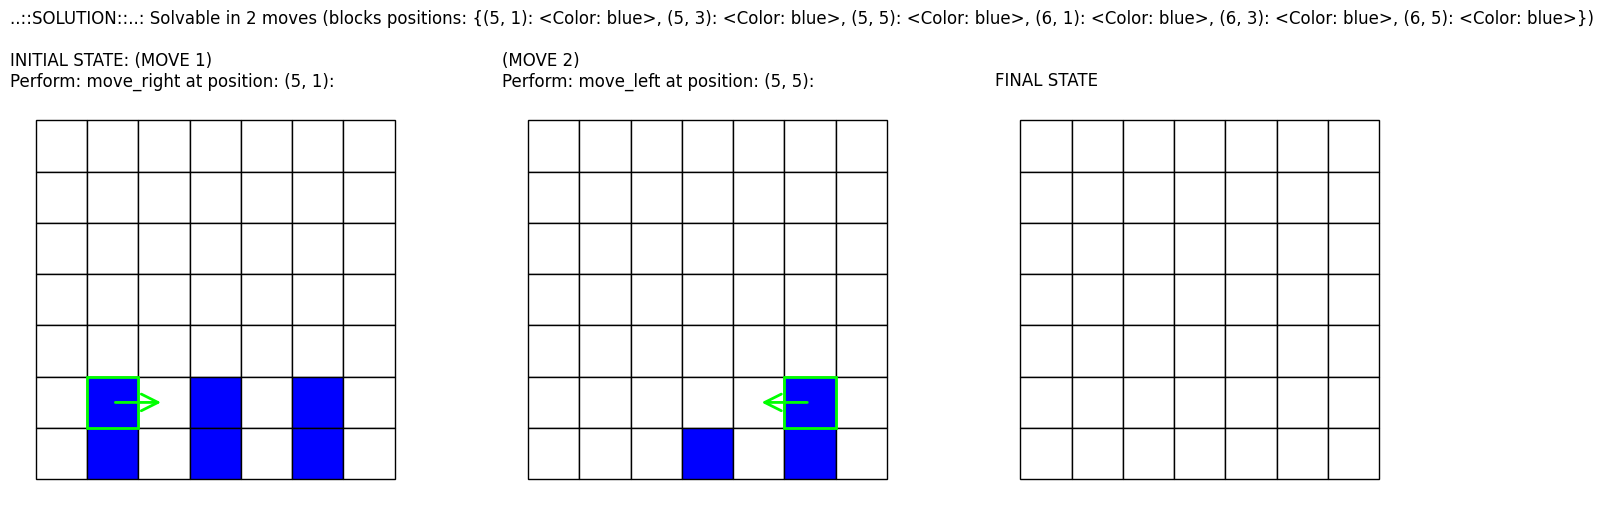

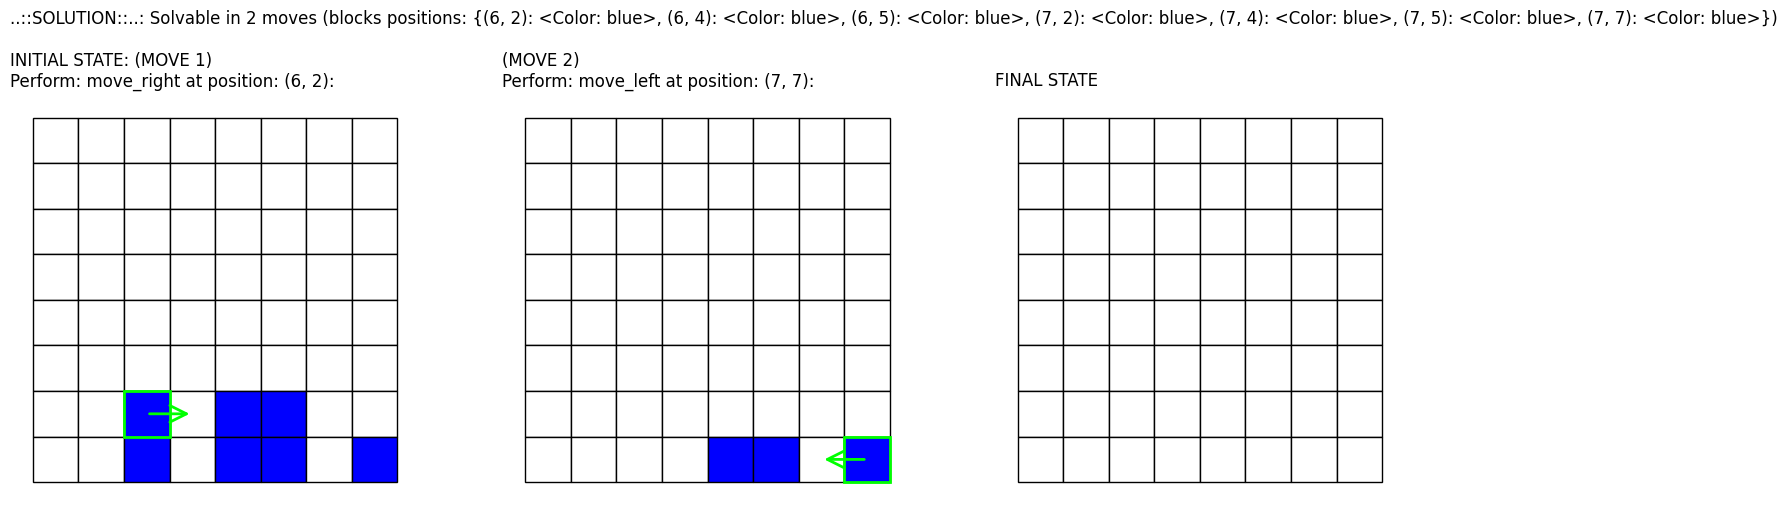

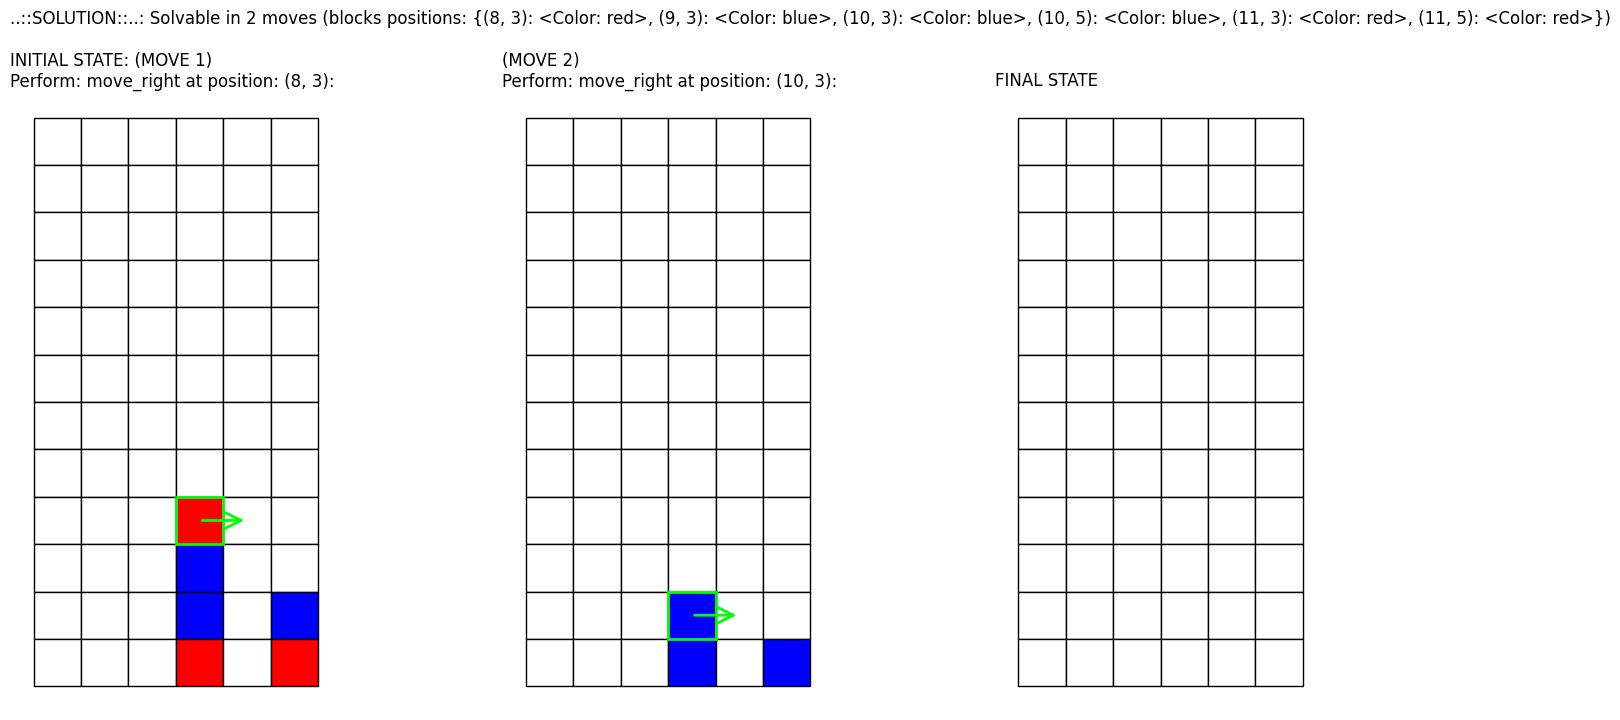

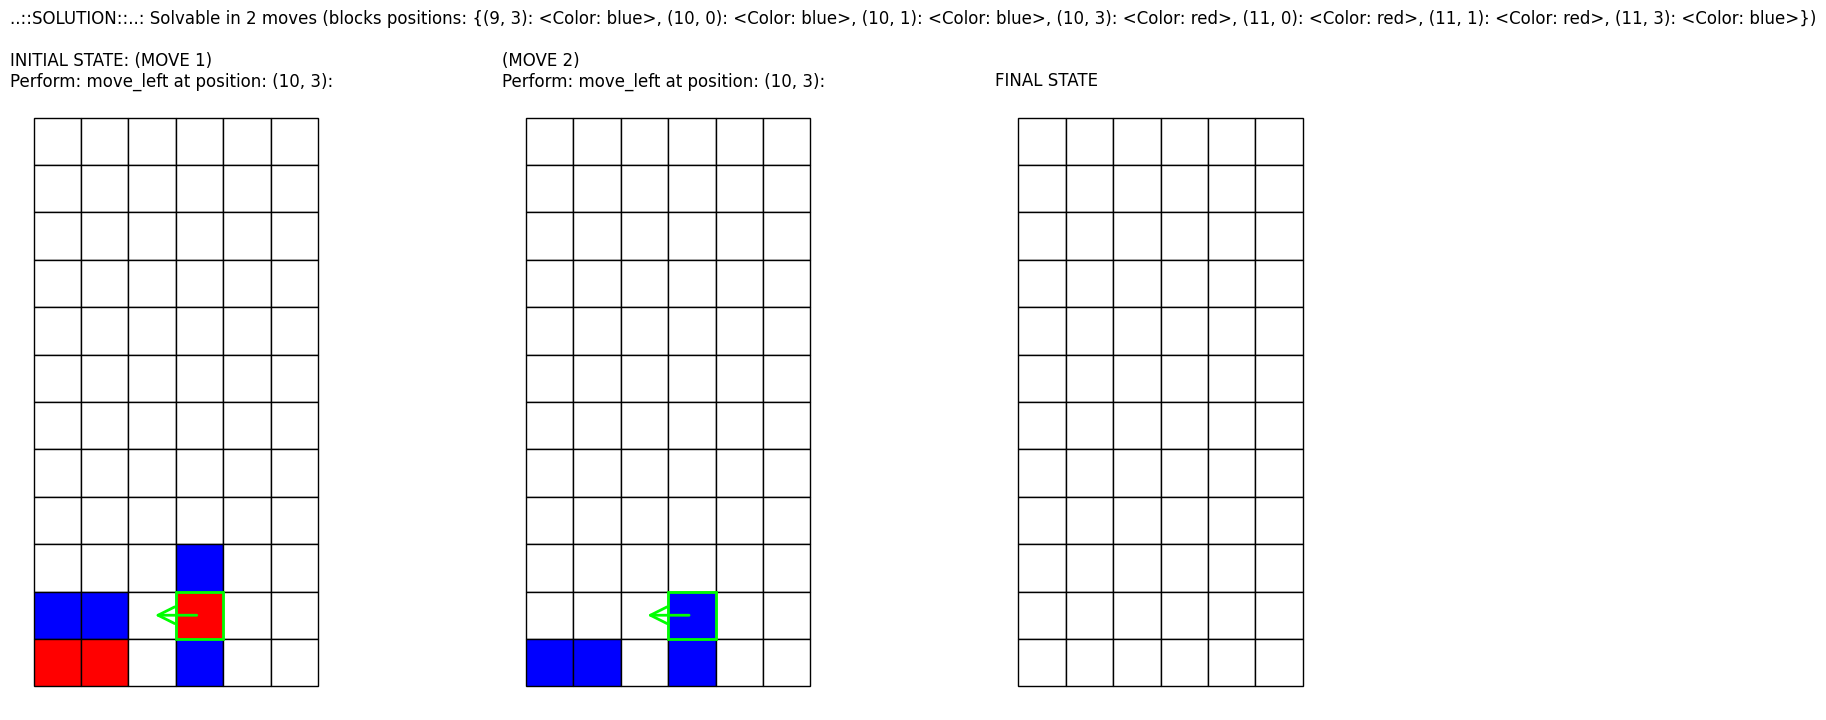

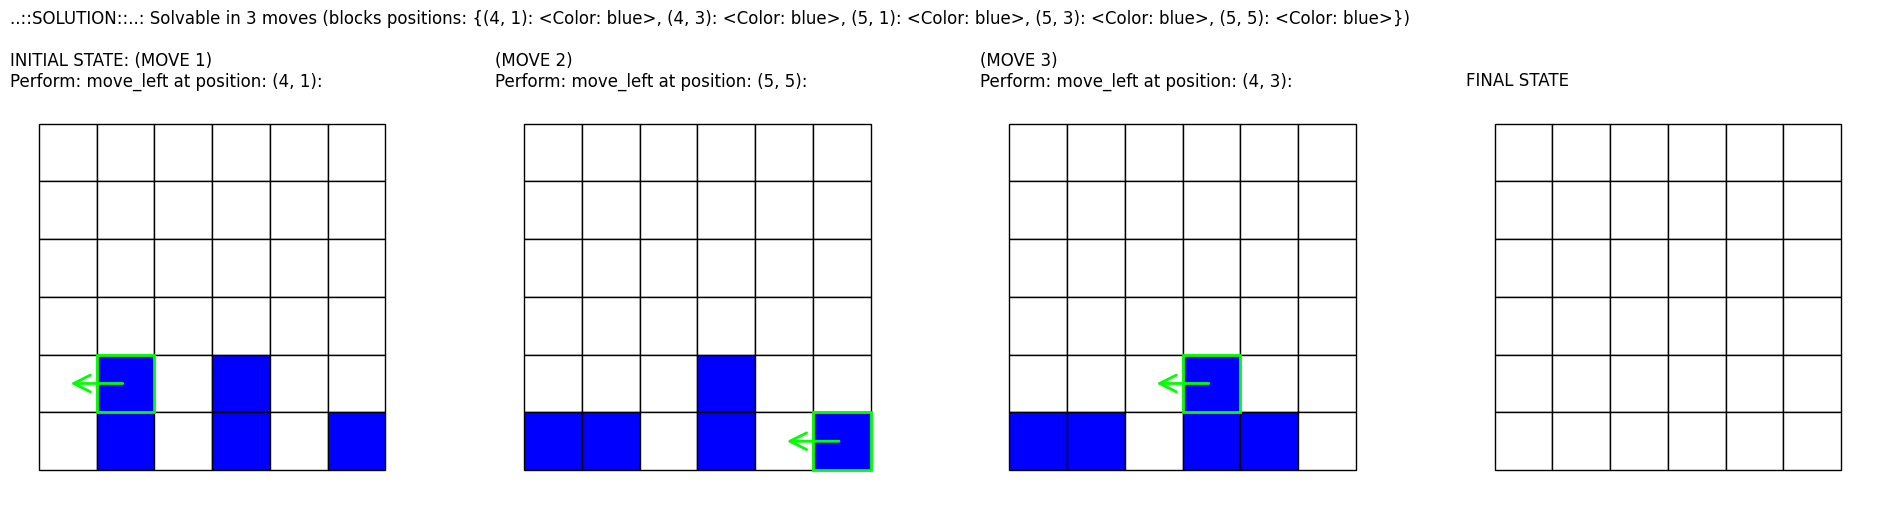

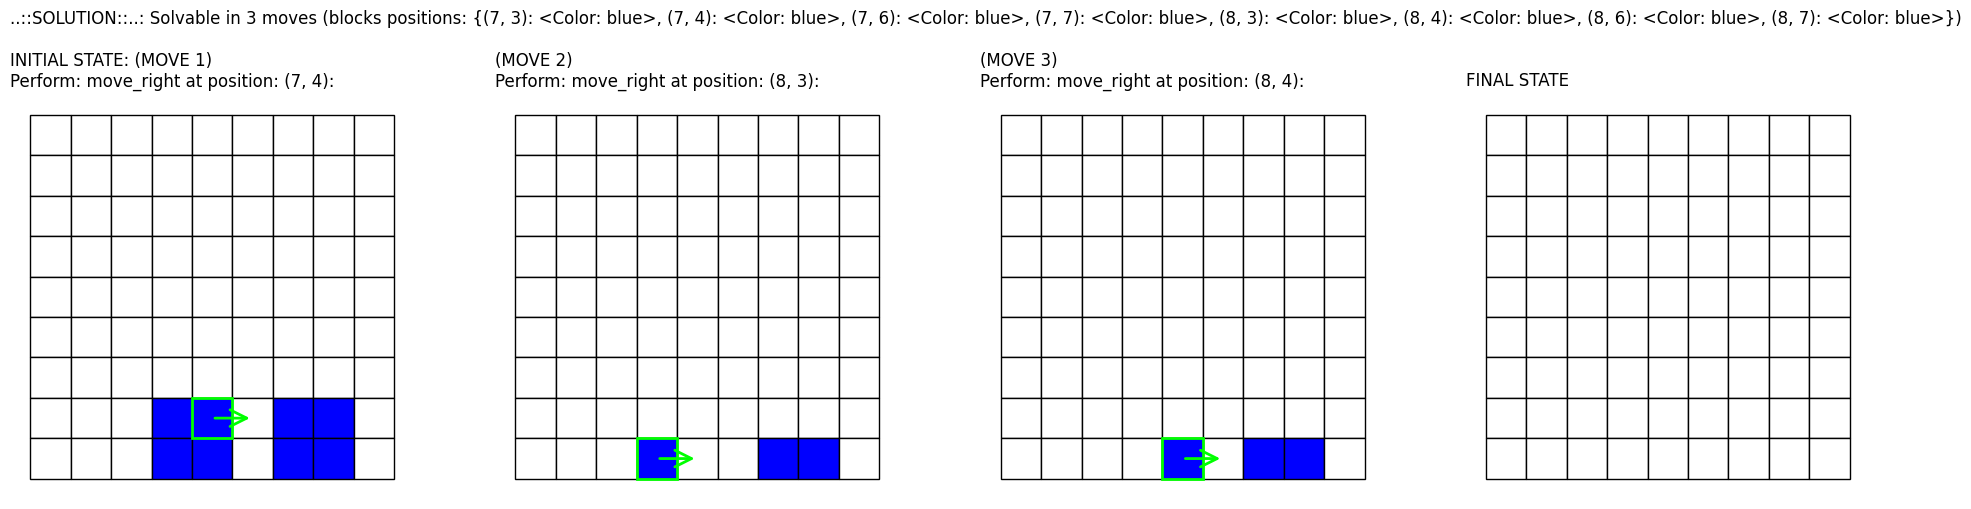

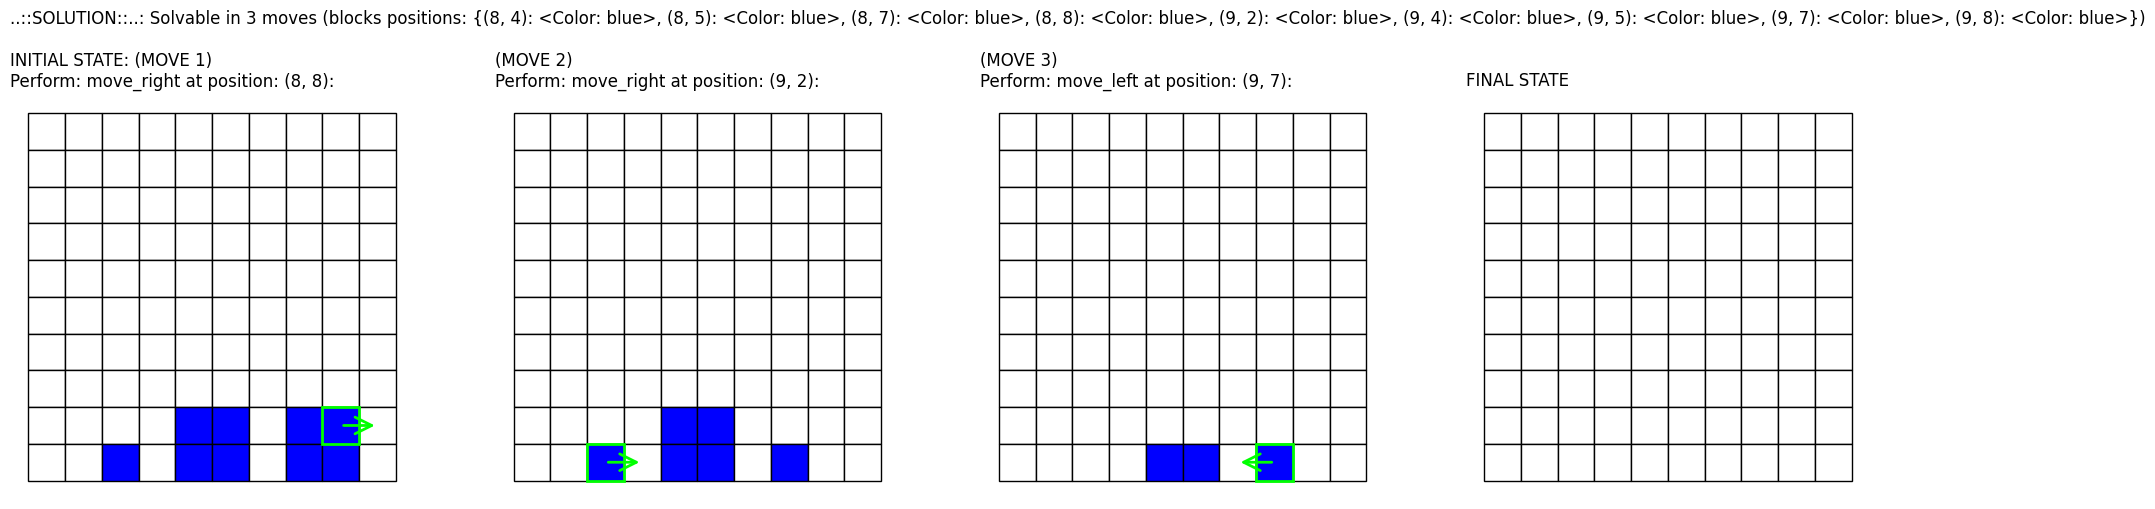

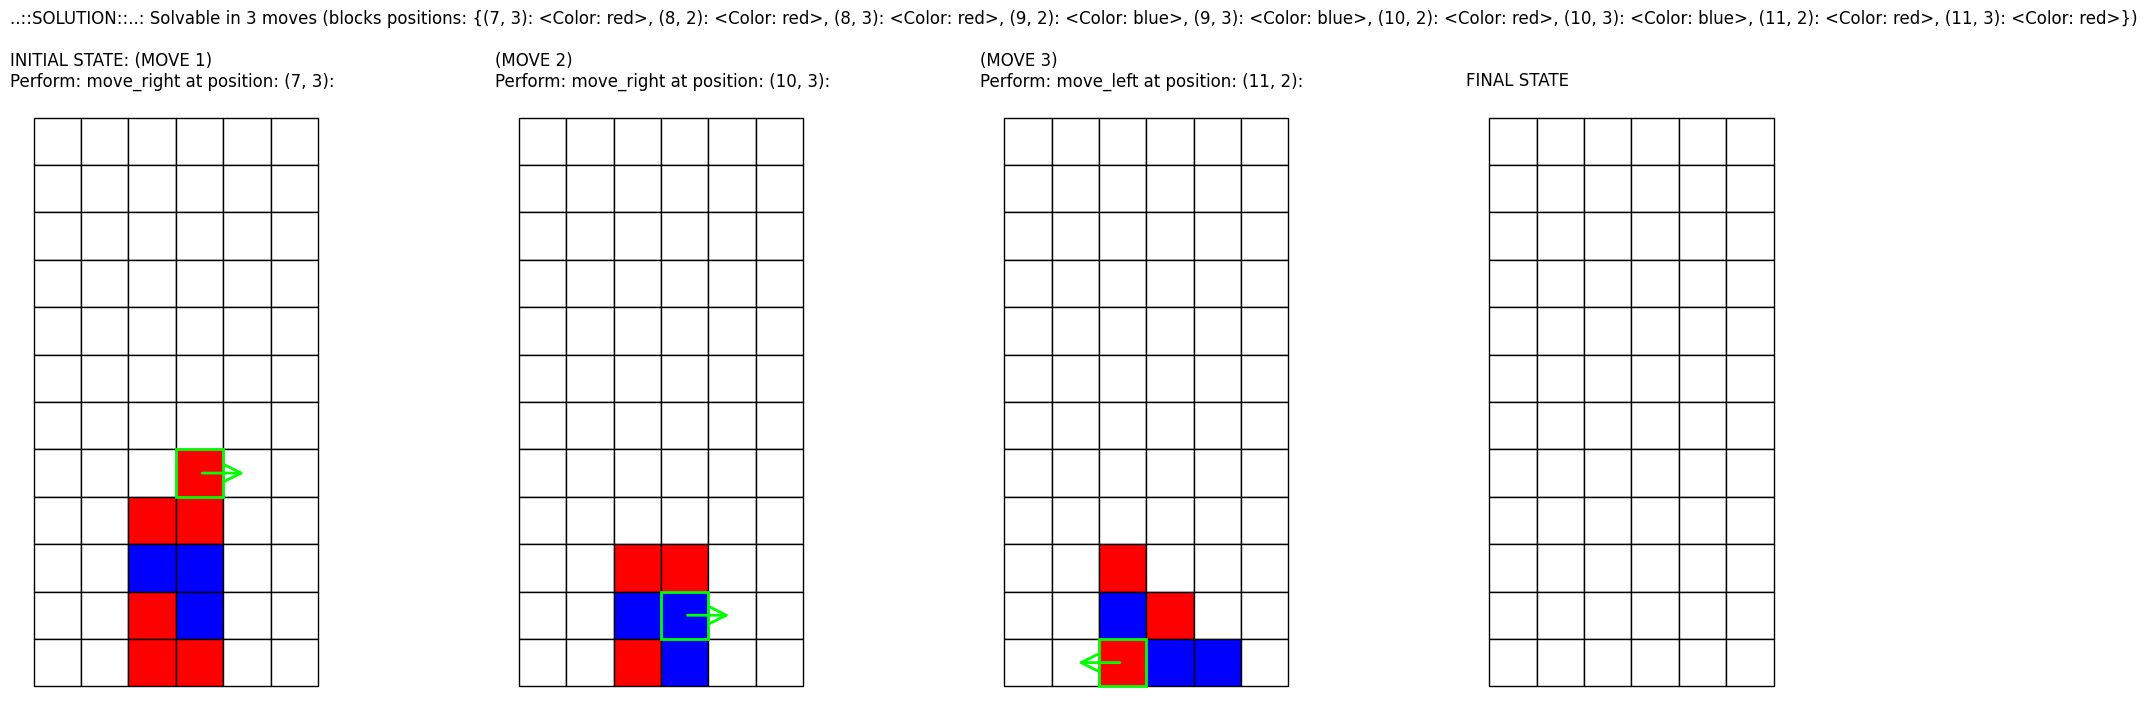

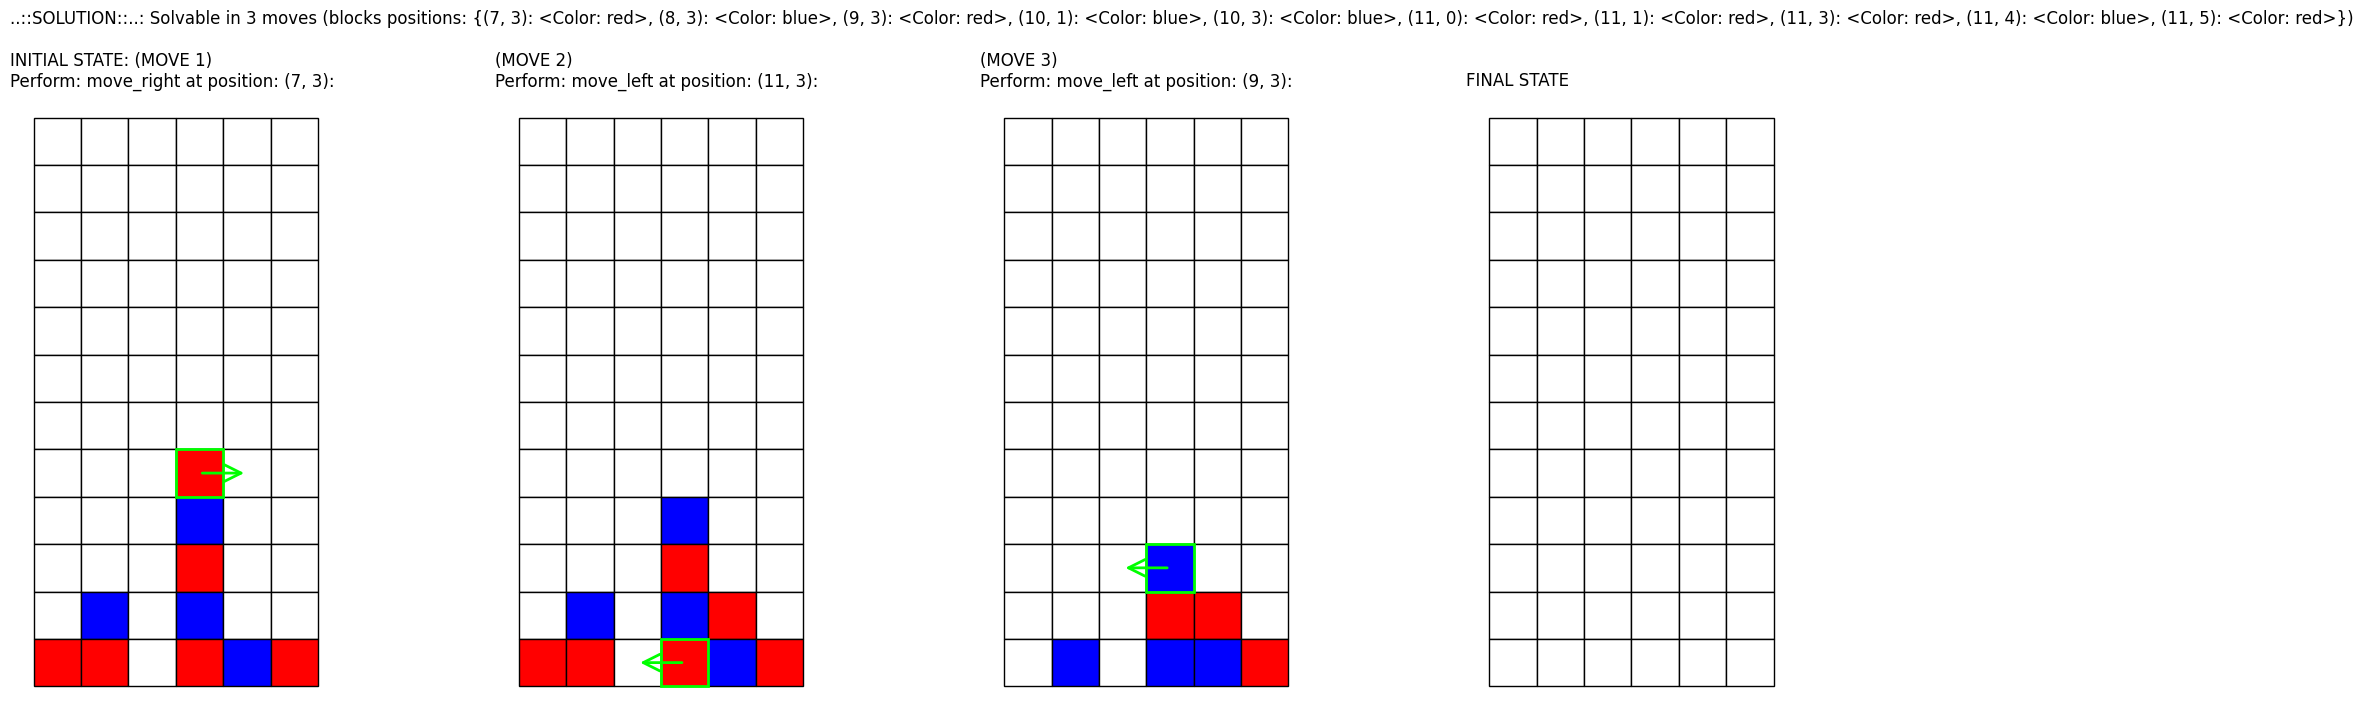

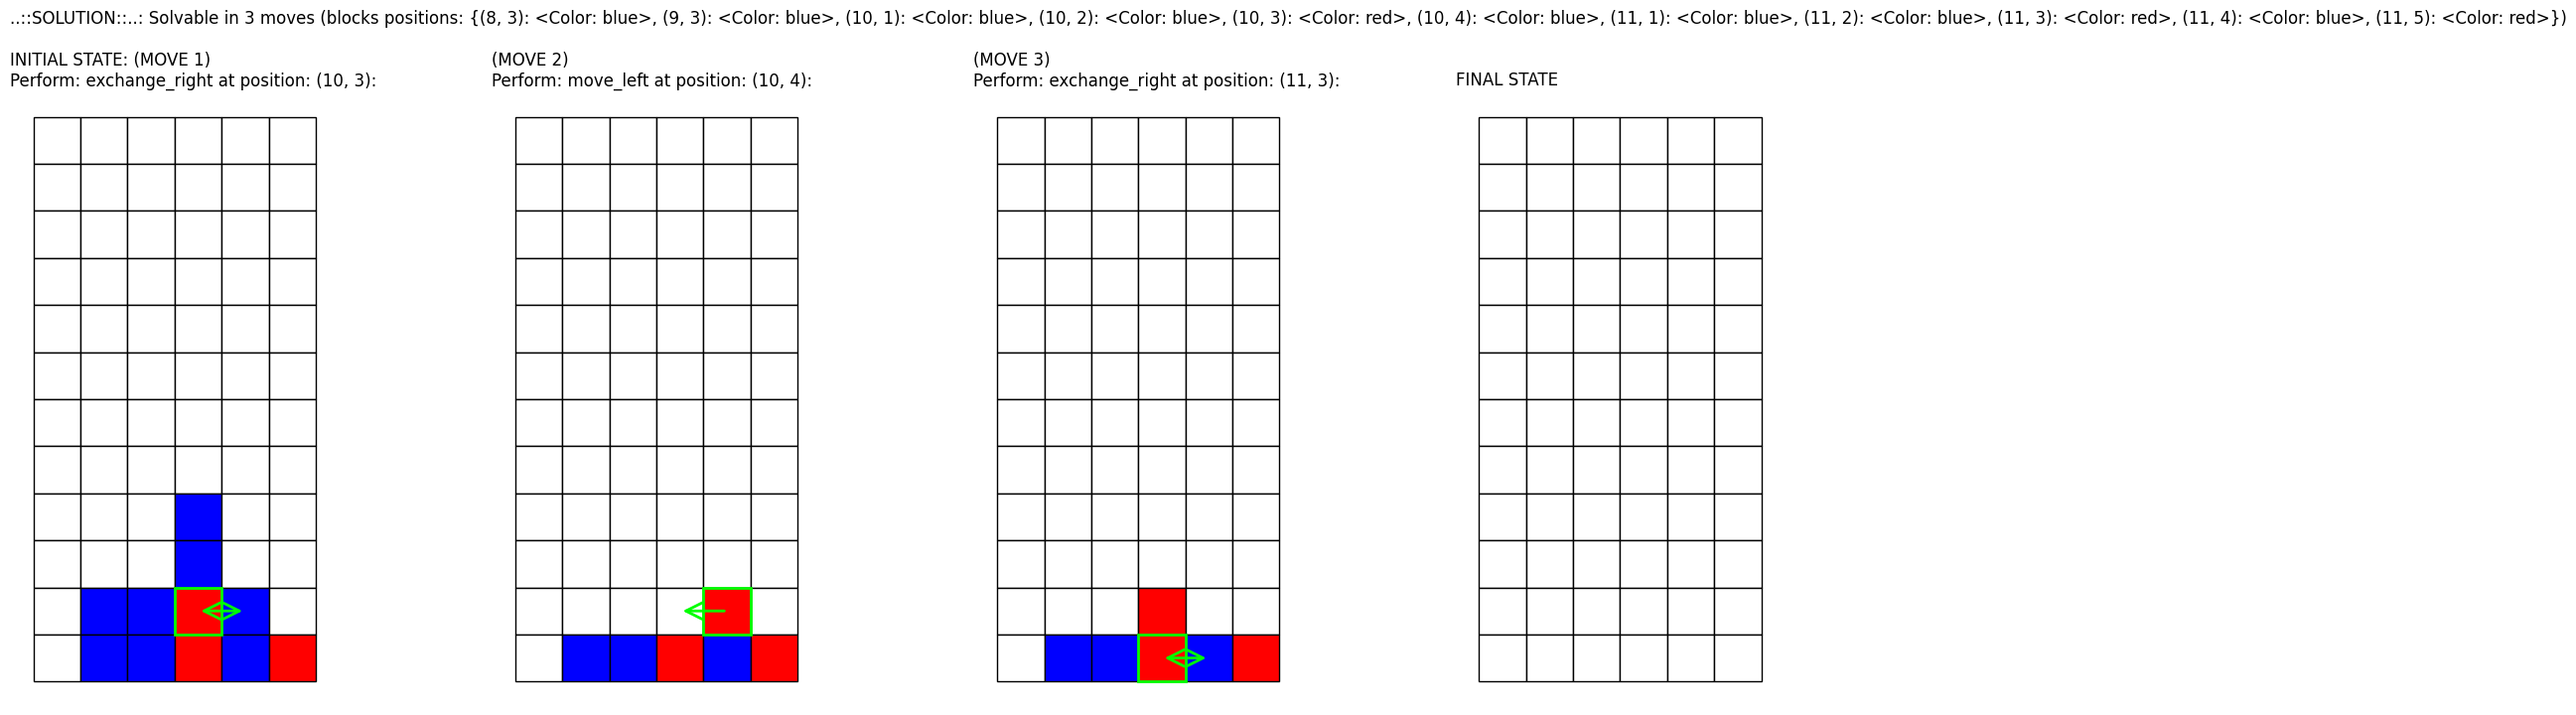

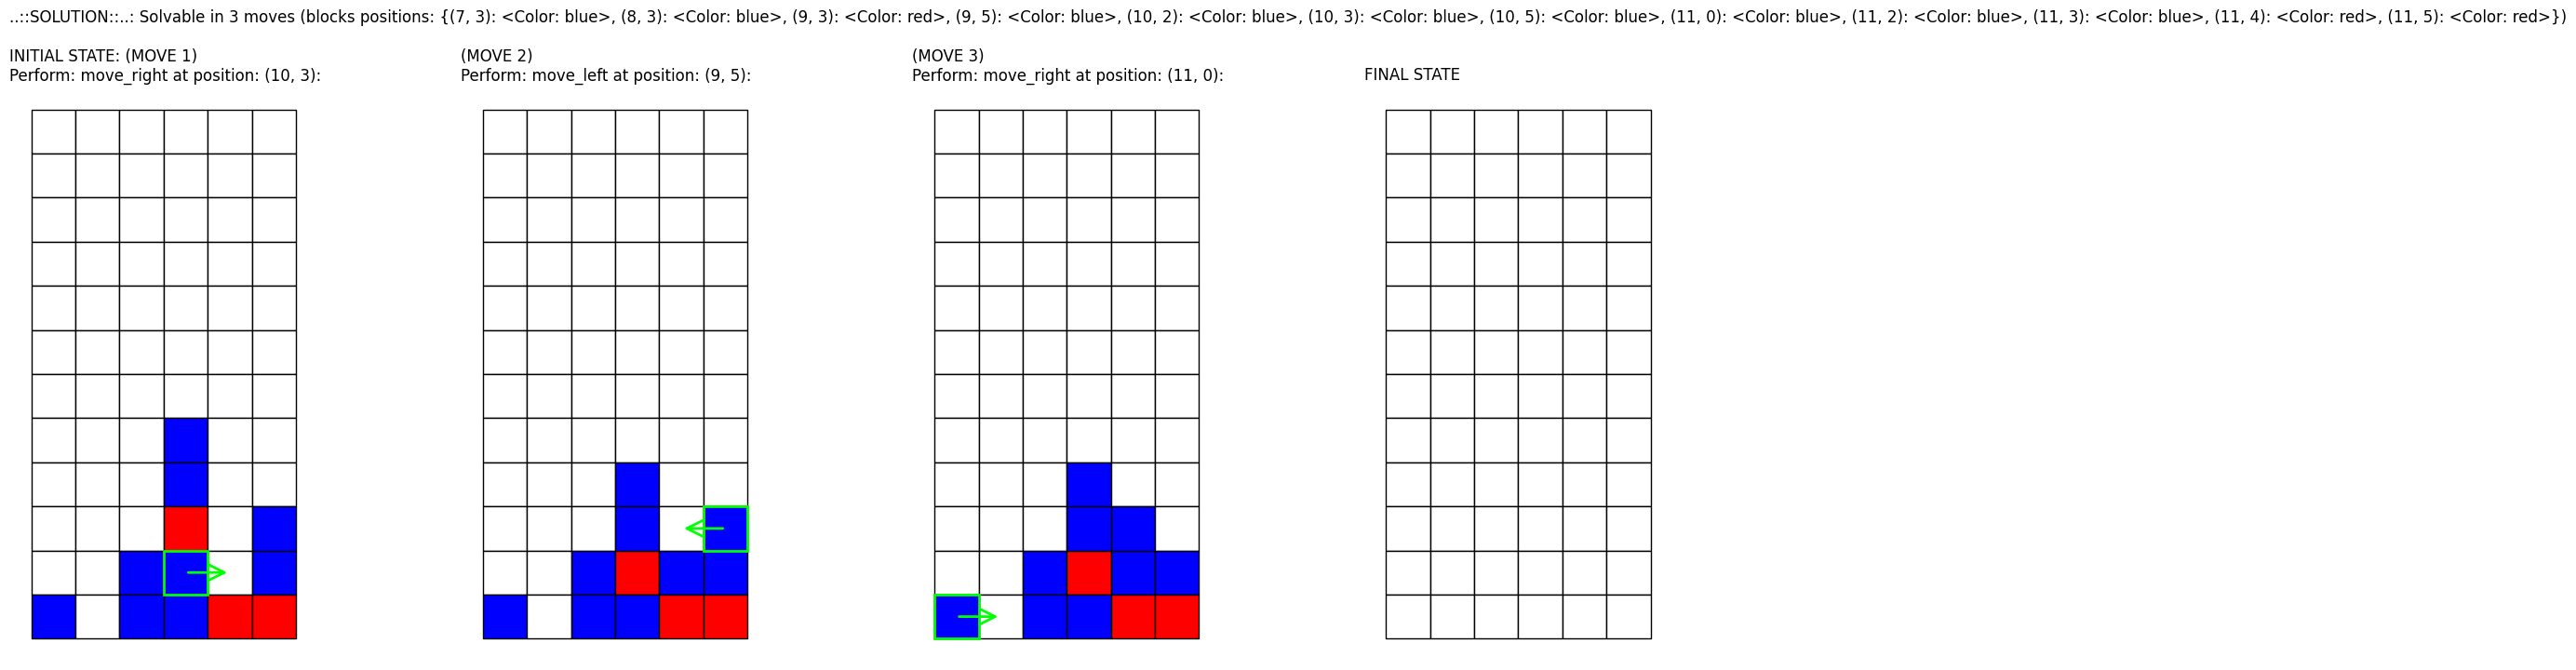

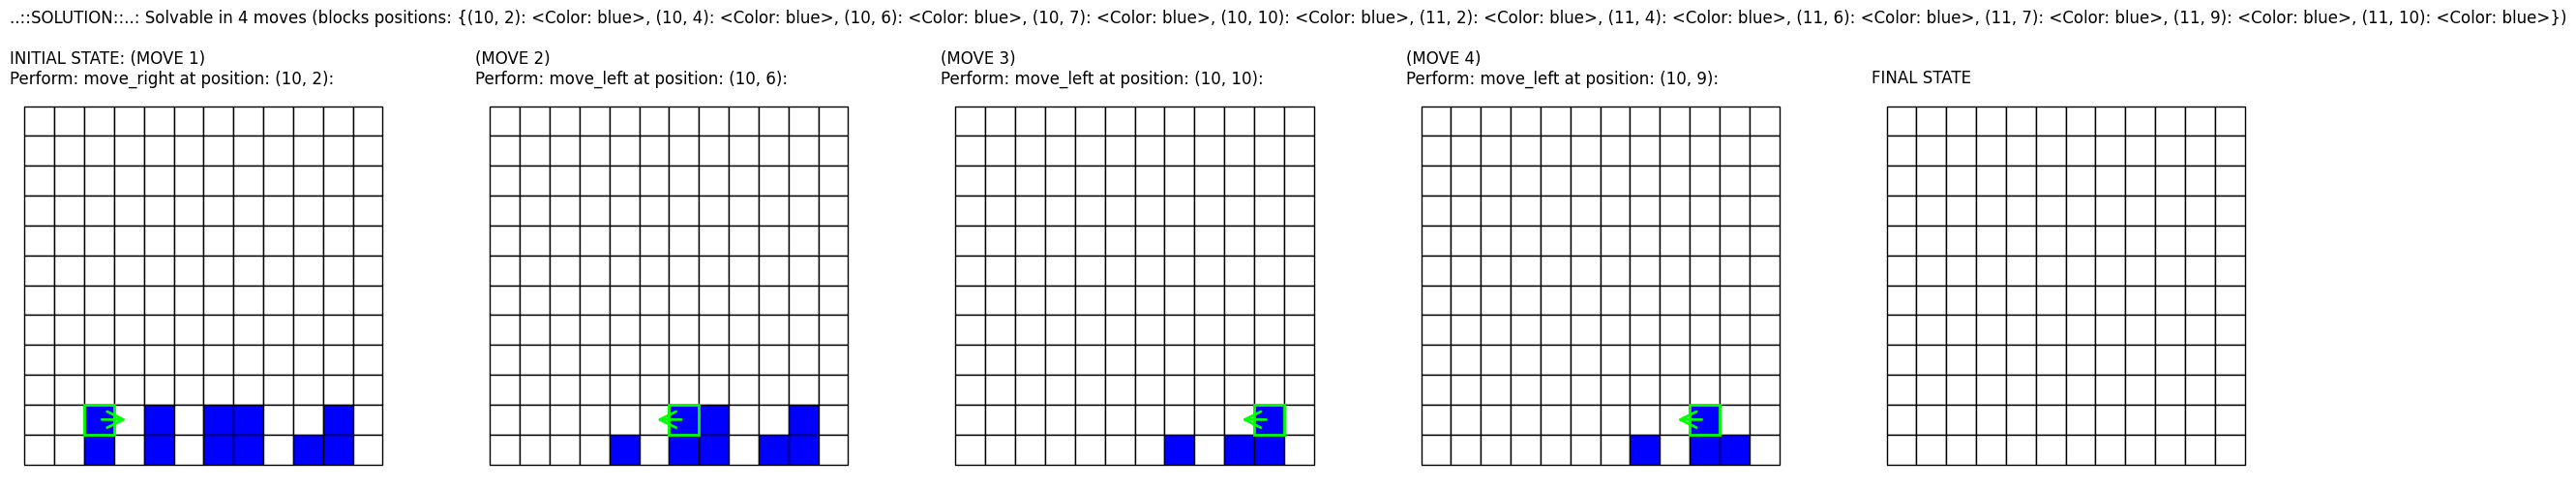

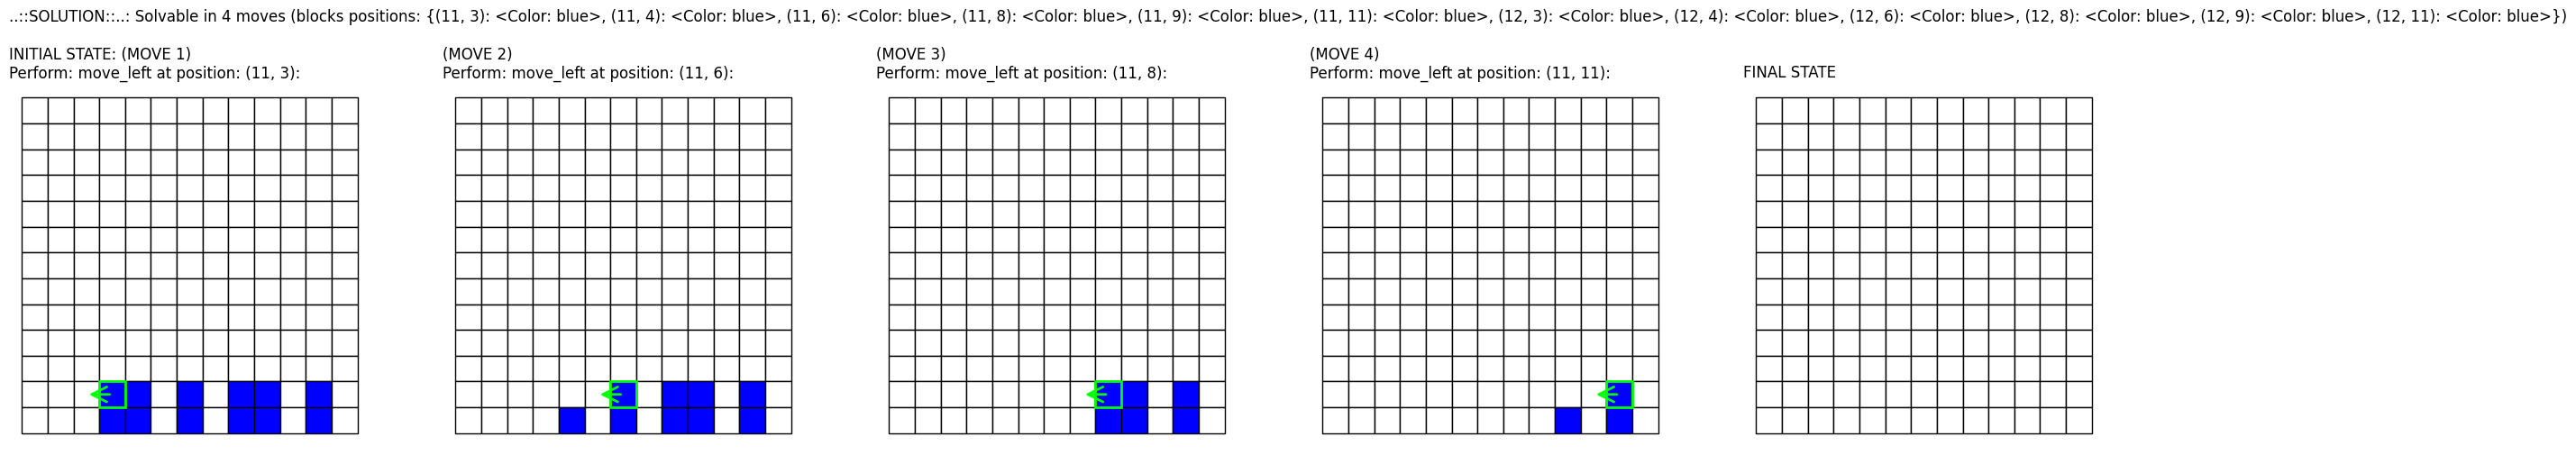

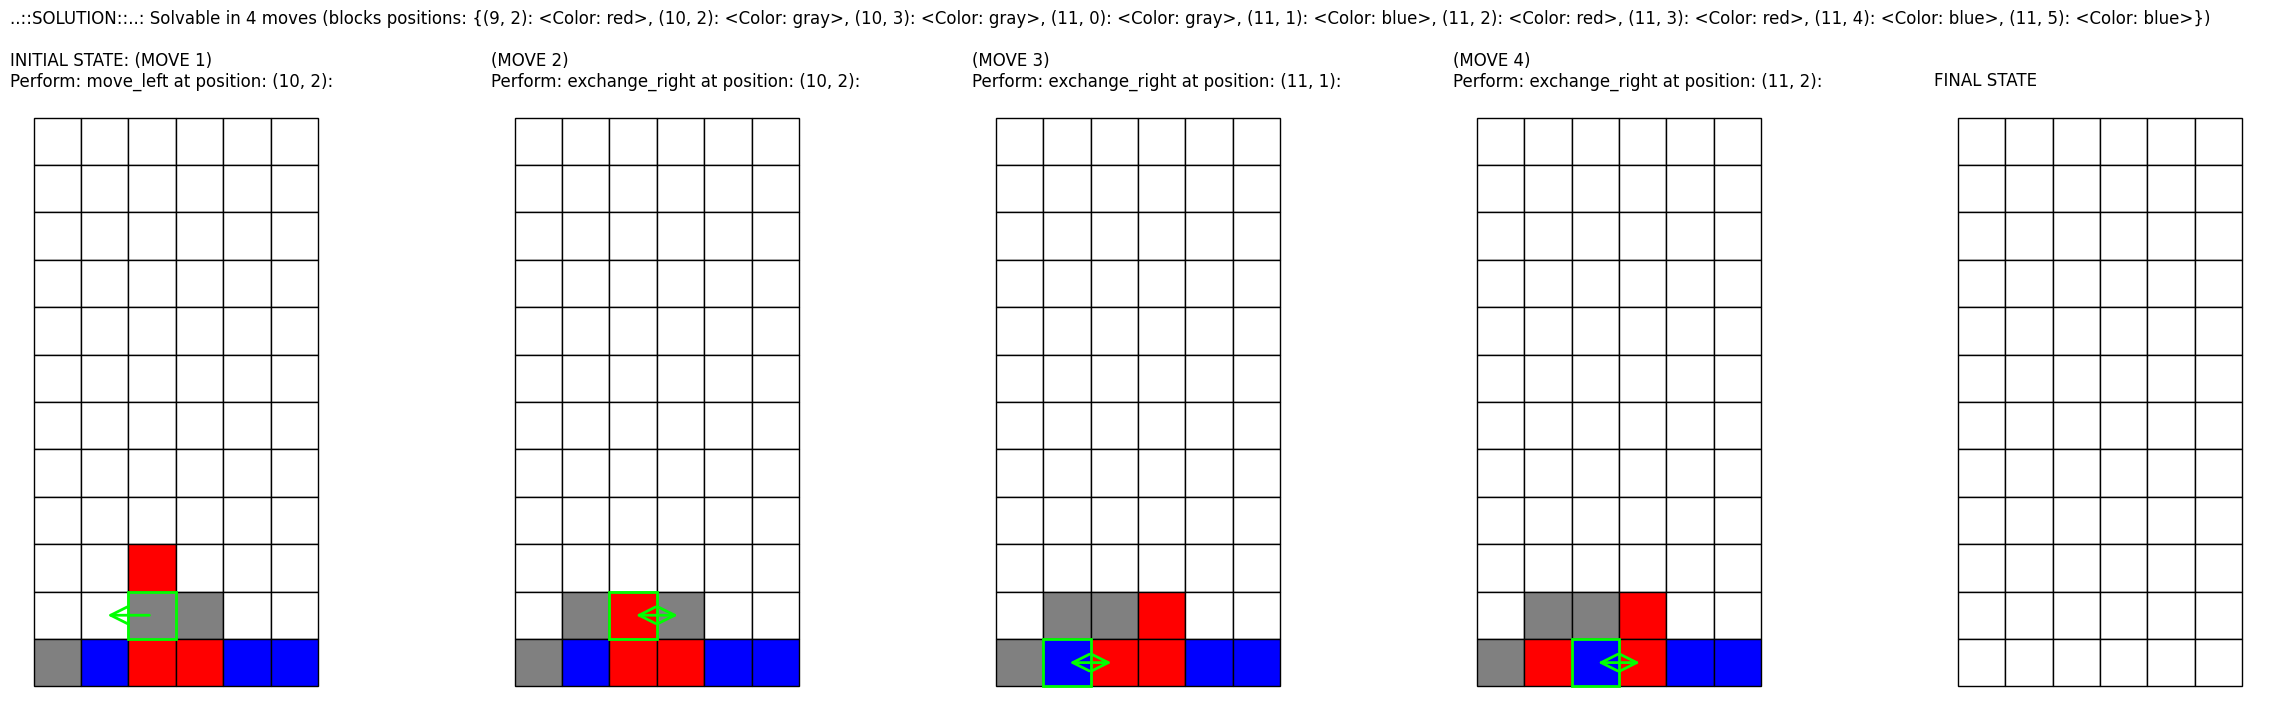

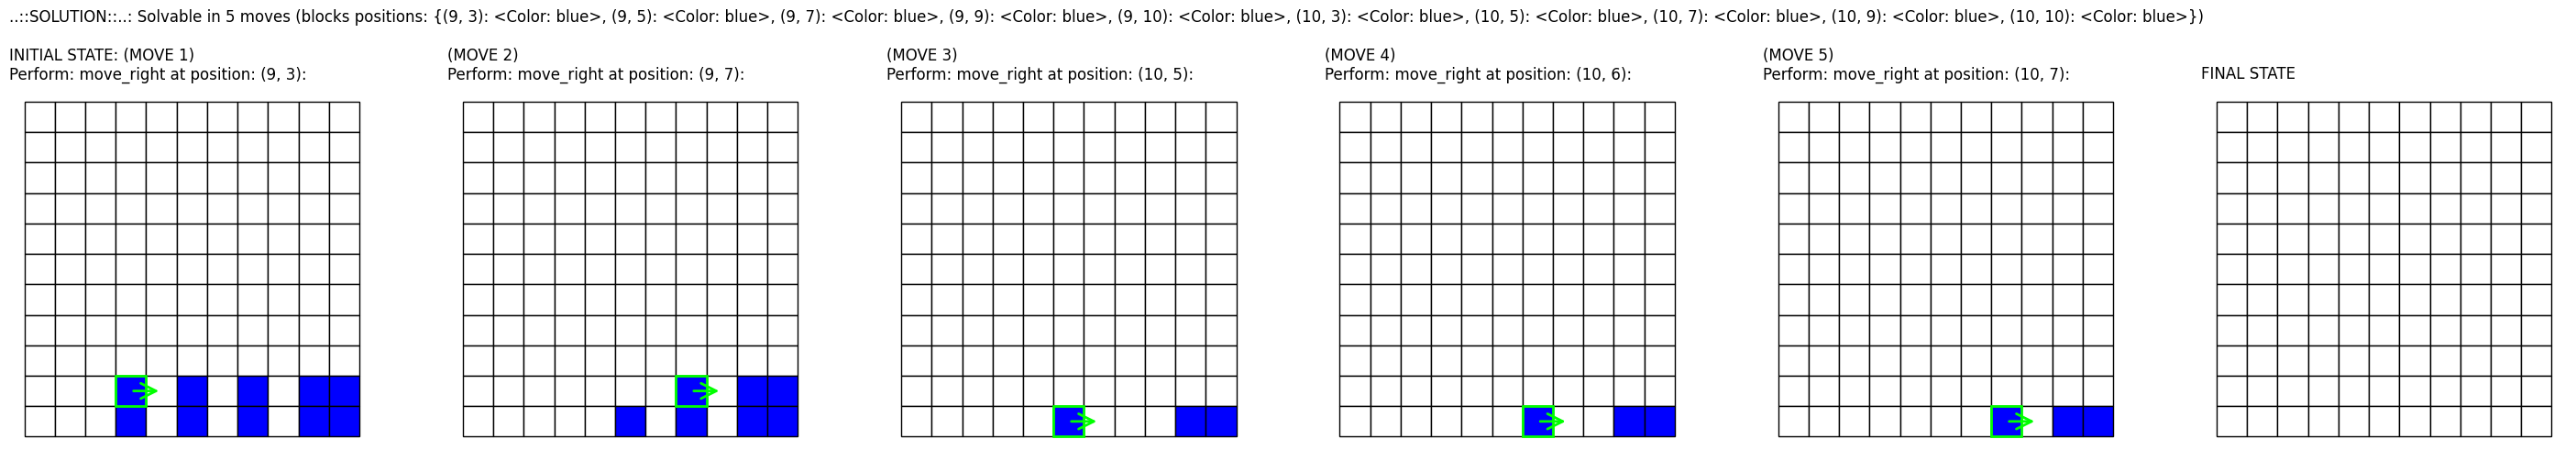

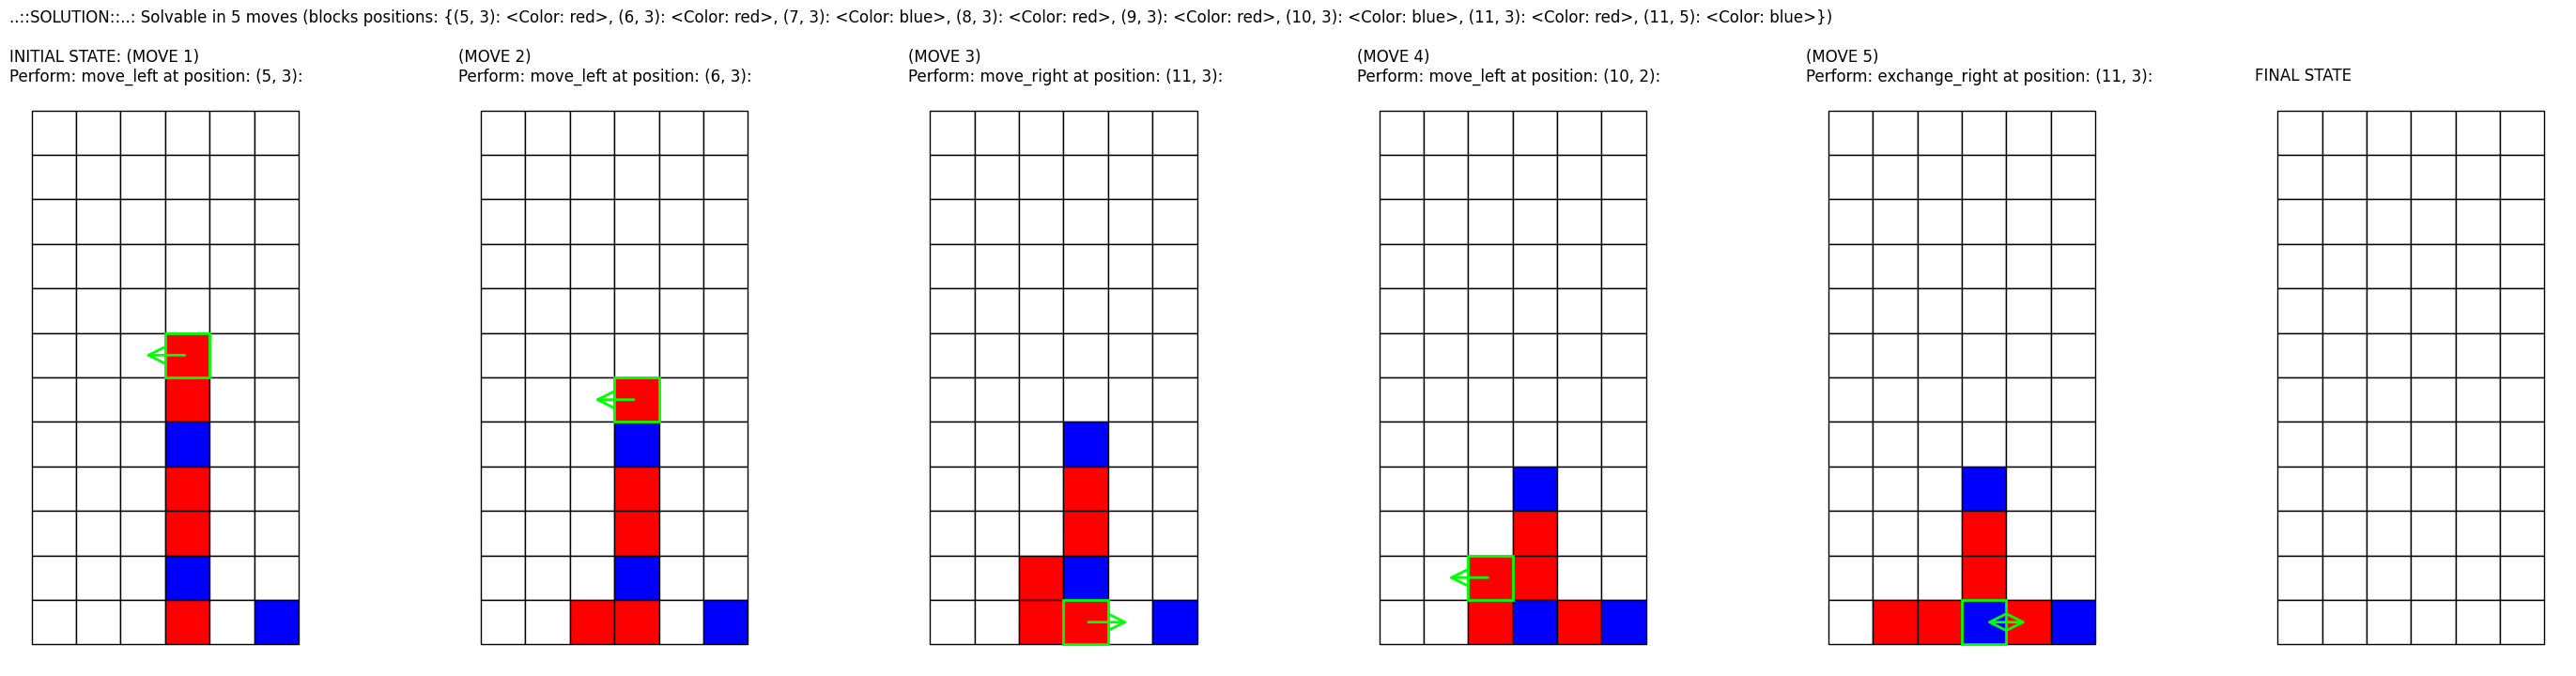

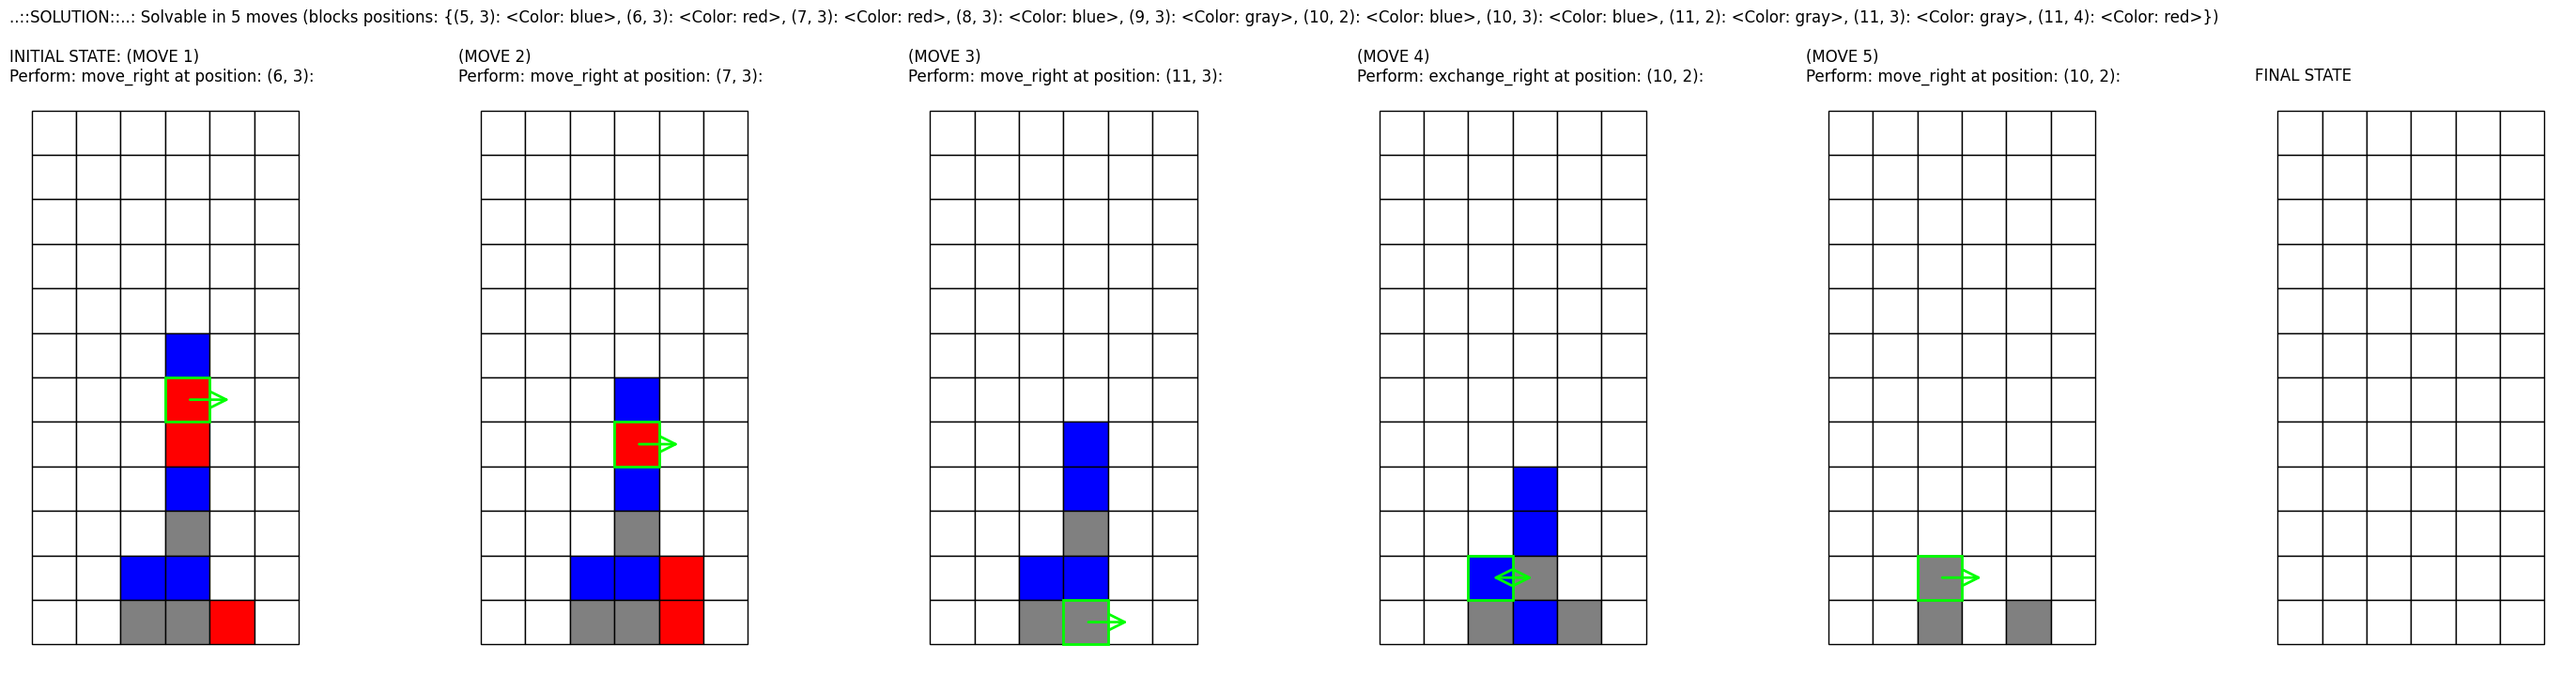

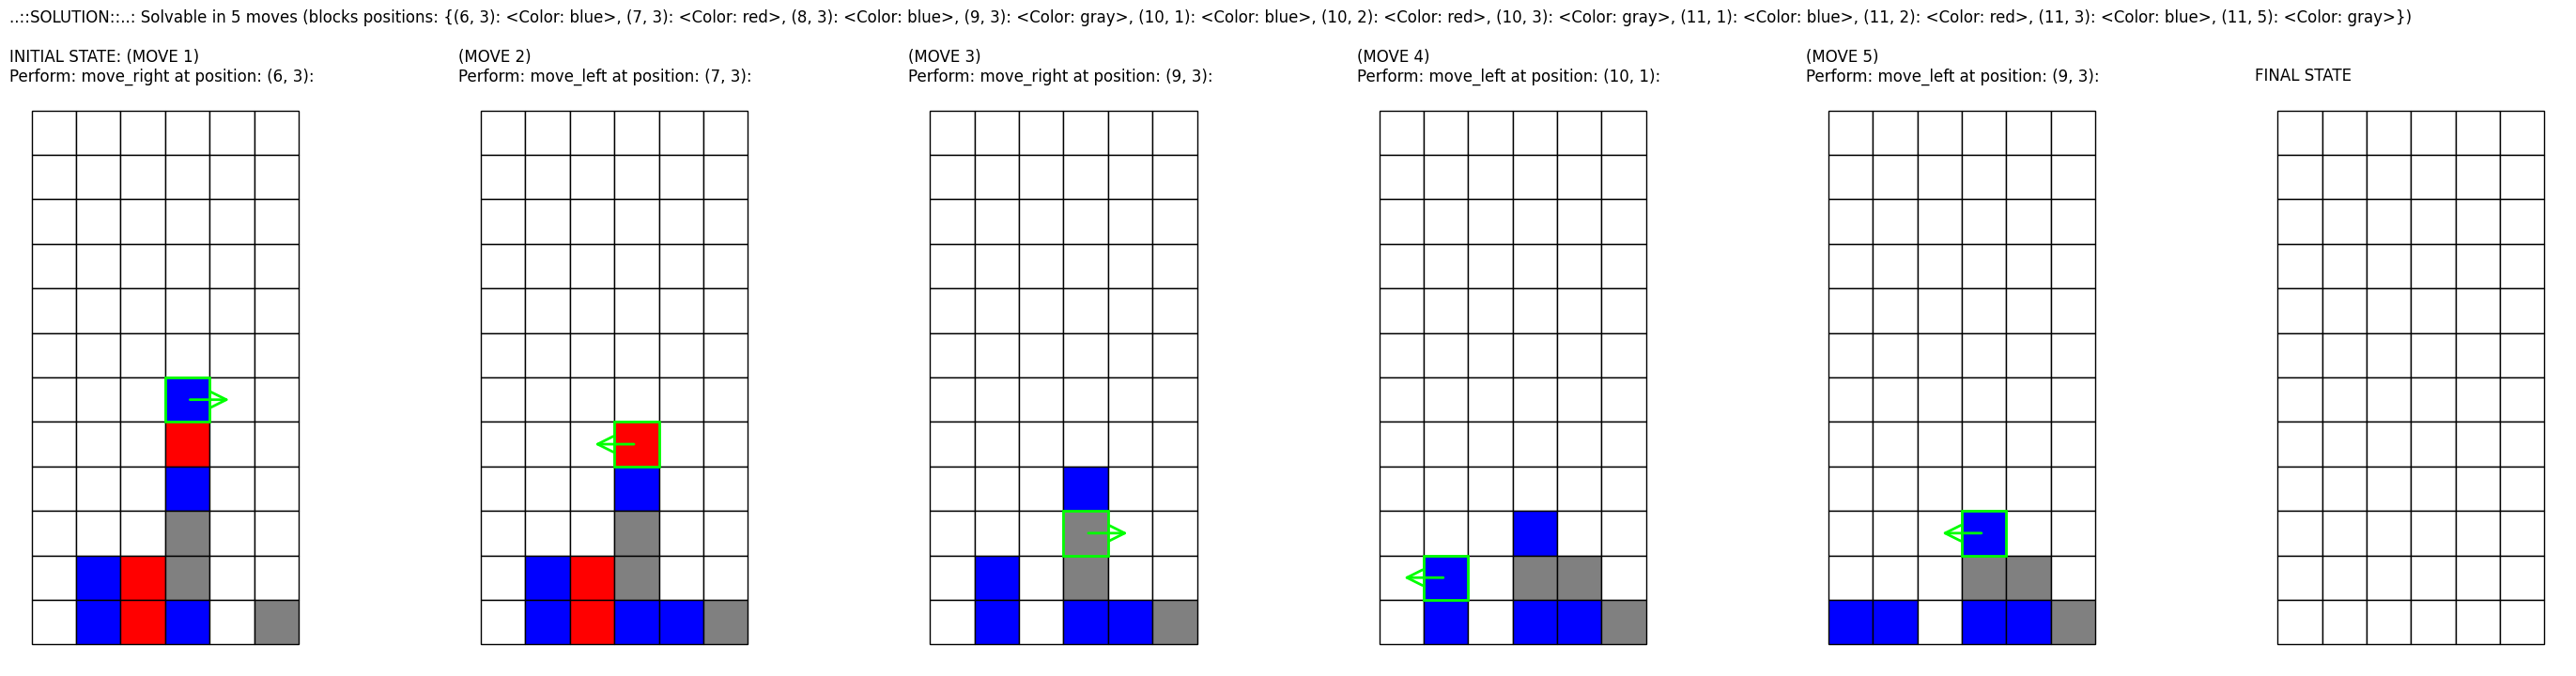

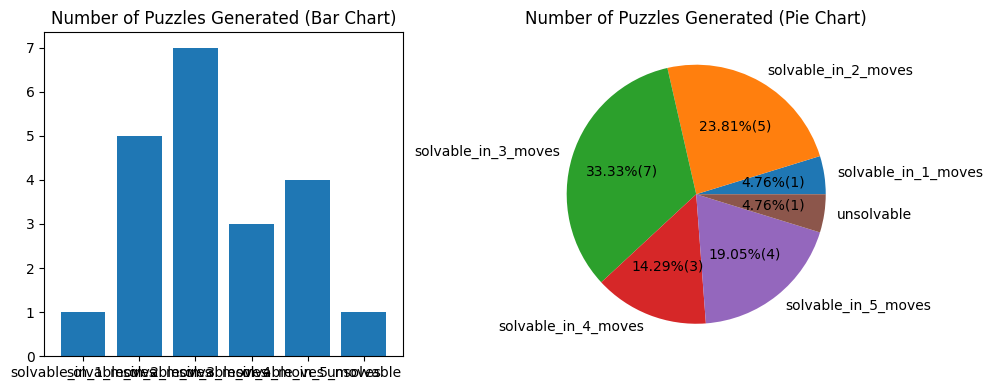

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Looks like we are on google colab so we file would be saved on our Kernel


In [ ]:
batch_generator.compute_stats()
batch_generator.print_and_save_batch()
batch_generator.save_results_as_csv()

Resources:
https://medium.com/swlh/solving-simplified-candy-crush-i-e-match-3-games-with-swaps-54cb7975486b
https://github.com/MohamadTarekk/EightPuzzle
https://www.youtube.com/watch?v=MQ-BffUgYfM
https://visualgo.net/en/dfsbfs
https://dev.to/lukegarrigan/what-is-bfs-breadth-first-search-nad

## Rapid tests for 1 puzzle

In [ ]:
nb_blocks = 10
colors = ['red', 'blue', 'gray']
nb_moves = 5
grid_size = (12, 6)
stack_probability = 0.5
blocks_gap = 1

if len(colors)*3 > nb_blocks:
  print('Not enough blocks for the number of colors. You need at least 3 blocks per color.')

Here is the randomly-created Puzzle: 


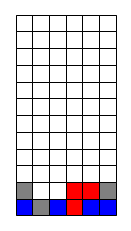


Or a shorter representation: 
 {(10, 0): <Color: gray>, (10, 3): <Color: red>, (10, 4): <Color: red>, (10, 5): <Color: gray>, (11, 0): <Color: blue>, (11, 1): <Color: gray>, (11, 2): <Color: blue>, (11, 3): <Color: red>, (11, 4): <Color: blue>, (11, 5): <Color: blue>}


In [ ]:
grid = GridInitializer(grid_size, nb_blocks, colors, nb_moves, stack_probability, blocks_gap)
grid.initialize_grid()
#set_blocks = {(0, 1): Block("X"),(1, 1): Block("X"),(2, 1): Block("O"),(3, 1): Block("X"),(4, 1): Block("X"),(4, 3): Block("O"),(4, 4): Block("O")}
#set_blocks = {(2, 1): Block("O"), (3, 1): Block("X"), (4, 1): Block("X"),(4, 2): Block("X"), (4, 3): Block("O"), (4, 4): Block("O")}
#grid.change_set_blocks(set_blocks)
grid.print_initial_grid()

In [ ]:
solver = BFSSolver(grid, PuzzleLogic())
is_solvable, solution = solver.perform_all_blocks_moves()
BFSSolver.print_history(solution, solver.grid_initializer.grid_size, True)

Did not find a solution in 5 moves. See the queue


KeyError: 'set_blocks_history'

In [ ]:

#Pruning, optimization(Astar) and parallelisation could improve the computation